# <u>Setup</u>

In [22]:
!which python

/mnt/2TB-HDD-Ubuntu/GitHub-Repositories/DeepRiskICU/venv/bin/python


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import datetime
import joblib
from tqdm import tqdm
from typing import Optional

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, average_precision_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import uniform, loguniform, randint
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

In [24]:
mimic_iii_path = '/mnt/2TB-HDD-Ubuntu/GitHub-Repositories/UT Austin/2025 Spring/AI-Healthcare/MIMIC-III-Dataset/mimic-iii-clinical-database-1.4'
PROCESSED_DATA_DIR = 'data/processed'

# embedding_type = 'clinicalBERT-unchunked'
embedding_type = 'clinicalBERT-chunked'
# embedding_type = 'biomedLM-chunked'

# <u>Load and Process Saved Training Data</u>

In [25]:
def assert_unique(df, col):
    assert df[col].nunique(dropna=True) == len(df), f'Some {col} have multiple rows'

## Load

In [26]:
labels = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'labels.csv'))
patients_data = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'patients.csv'), parse_dates=['dob'])
admissions_data = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'admissions.csv'), parse_dates=['admission_dt'])
notes_data = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'notes.csv'), parse_dates=['note_dt'])
prescriptions_data = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'prescriptions.csv'), parse_dates=['rx_start_date'])

In [27]:
assert_unique(labels, 'admission_id')
print(labels.info())
labels

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43407 entries, 0 to 43406
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   admission_id  43407 non-null  int64
 1   death         43407 non-null  bool 
dtypes: bool(1), int64(1)
memory usage: 381.6 KB
None


,admission_id,death
0,165315,False
1,124321,False
2,161859,False
3,129635,False
4,197661,False
...,...,...
43402,105447,True
43403,191113,False
43404,101071,True
43405,170407,False


In [28]:
assert_unique(patients_data, 'patient_id')
print(patients_data.info())
patients_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33591 entries, 0 to 33590
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   patient_id  33591 non-null  int64         
 1   gender      33591 non-null  object        
 2   dob         33591 non-null  datetime64[ns]
 3   ethnicity   33591 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 1.0+ MB
None


,patient_id,gender,dob,ethnicity
0,22,female,2131-05-07,white
1,23,male,2082-07-17,white
2,24,male,2100-05-31,white
3,25,male,2101-11-21,white
4,26,male,2054-05-04,other
...,...,...,...,...
33586,98769,female,2044-10-22,white
33587,98790,male,2147-03-18,white
33588,98797,male,2044-12-27,white
33589,98800,female,2111-11-05,white


In [29]:
assert_unique(admissions_data, 'admission_id')
print(admissions_data.info())
admissions_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43407 entries, 0 to 43406
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   patient_id          43407 non-null  int64         
 1   admission_id        43407 non-null  int64         
 2   admission_dt        43407 non-null  datetime64[ns]
 3   admission_location  43407 non-null  object        
 4   insurance_type      43407 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 1.7+ MB
None


,patient_id,admission_id,admission_dt,admission_location,insurance_type
0,22,165315,2196-04-09 12:26:00,er,private
1,23,124321,2157-10-18 19:34:00,transfer,medicare
2,24,161859,2139-06-06 16:14:00,transfer,private
3,25,129635,2160-11-02 02:06:00,er,private
4,26,197661,2126-05-06 15:16:00,transfer,medicare
...,...,...,...,...,...
43402,98797,105447,2132-12-24 20:06:00,er,medicare
43403,98800,191113,2131-03-30 21:13:00,clinic_ref,private
43404,98802,101071,2151-03-05 20:00:00,clinic_ref,medicare
43405,98813,170407,2128-11-11 02:29:00,er,private


In [30]:
print(notes_data.info())
notes_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229486 entries, 0 to 229485
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   note_id       229486 non-null  int64         
 1   admission_id  229486 non-null  float64       
 2   note_dt       229486 non-null  datetime64[ns]
 3   note_text     229486 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 7.0+ MB
None


,note_id,admission_id,note_dt,note_text
0,0,136227.0,2193-02-08 15:39:00,Attending Physician: [**Name10 (NameIs) 116**]...
1,1,157324.0,2154-03-25 07:02:00,"Chief Complaint: 75F with COPD, DM, [**Hospita..."
2,2,157324.0,2154-03-25 07:02:00,"Chief Complaint: 75F with COPD, DM, [**Hospita..."
3,3,157324.0,2154-03-25 07:02:00,"Chief Complaint: 75F with COPD, DM, [**Hospita..."
4,4,165003.0,2138-02-11 05:09:00,"Pneumonia, other\n Assessment:\n Afebrile,..."
...,...,...,...,...
229481,229481,122817.0,2150-11-13 14:37:00,Clinical Nutrition:\nO:\n~Former 24 [**4-8**] ...
229482,229482,122817.0,2150-11-12 18:08:00,Respiratory Care Note\nBaby Girl [**Known last...
229483,229483,122817.0,2150-11-12 22:39:00,NICU NSG NOTE\n\n\n#1. Resp. O/ Conts on HFOV ...
229484,229484,122817.0,2150-11-13 03:20:00,"1. Resp: O: Received infant on the HiFi vent, ..."


In [31]:
print(prescriptions_data.info())
prescriptions_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1265014 entries, 0 to 1265013
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   rx_id          1265014 non-null  int64         
 1   admission_id   1265014 non-null  int64         
 2   rx_start_date  1265014 non-null  datetime64[ns]
 3   rx_name        1265014 non-null  object        
 4   rx_dose        1265014 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 48.3+ MB
None


,rx_id,admission_id,rx_start_date,rx_name,rx_dose
0,0,143045,2167-01-08,D5W,HEPARIN BASE
1,1,143045,2167-01-08,Heparin Sodium,"25,000 unit Premix Bag"
2,2,143045,2167-01-08,Nitroglycerin,100MG/250 PM
3,3,143045,2167-01-08,Docusate Sodium,100MG CAP
4,4,143045,2167-01-08,Insulin,Dummy Pkg for POE pump and PHA SS ordering
...,...,...,...,...,...
1265009,1265009,121032,2144-09-06,PredniSONE,20 mg Tablet
1265010,1265010,121032,2144-09-06,Ipratropium Bromide Neb,2.5mL Vial
1265011,1265011,121032,2144-09-06,HYDROmorphone (Dilaudid),20 mg / 100 mL Premix Bag
1265012,1265012,121032,2144-09-06,Docusate Sodium,100mg Capsule


## Feature Extraction

### Patients/Admissions

In [32]:
patients_admissions_data = pd.merge(
    patients_data,
    admissions_data,
    on='patient_id',
    how='inner'
)
assert_unique(patients_admissions_data, 'admission_id')
# patients_admissions_data.drop(columns='patient_id', inplace=True) need to drop after getting final patient count

print(patients_admissions_data.info())
patients_admissions_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43407 entries, 0 to 43406
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   patient_id          43407 non-null  int64         
 1   gender              43407 non-null  object        
 2   dob                 43407 non-null  datetime64[ns]
 3   ethnicity           43407 non-null  object        
 4   admission_id        43407 non-null  int64         
 5   admission_dt        43407 non-null  datetime64[ns]
 6   admission_location  43407 non-null  object        
 7   insurance_type      43407 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 2.6+ MB
None


,patient_id,gender,dob,ethnicity,admission_id,admission_dt,admission_location,insurance_type
0,22,female,2131-05-07,white,165315,2196-04-09 12:26:00,er,private
1,23,male,2082-07-17,white,124321,2157-10-18 19:34:00,transfer,medicare
2,24,male,2100-05-31,white,161859,2139-06-06 16:14:00,transfer,private
3,25,male,2101-11-21,white,129635,2160-11-02 02:06:00,er,private
4,26,male,2054-05-04,other,197661,2126-05-06 15:16:00,transfer,medicare
...,...,...,...,...,...,...,...,...
43402,98769,female,2044-10-22,white,141860,2125-02-22 22:18:00,clinic_ref,medicare
43403,98790,male,2147-03-18,white,187987,2200-10-15 01:58:00,er,private
43404,98797,male,2044-12-27,white,105447,2132-12-24 20:06:00,er,medicare
43405,98800,female,2111-11-05,white,191113,2131-03-30 21:13:00,clinic_ref,private


#### Calculate Age

In [33]:
from pandas._libs.tslibs.np_datetime import OutOfBoundsDatetime

# Calculate age safely with error handling for extreme date ranges
def calculate_age(admit_date, birth_date):
    try:
        return (admit_date - birth_date).days / 365
    except (OverflowError, OutOfBoundsDatetime):
        # If dates are too extreme, check if year difference is reasonable
        year_diff = admit_date.year - birth_date.year
        if 0 <= year_diff <= 120:  # Reasonable age range
            return year_diff
        else:
            print(f'admission_id: {admit_date} - {birth_date} has unreasonable age difference: {year_diff}')
            return float('nan')  # Return NaN for unreasonable values

# Apply the safer calculation
patients_admissions_data['age_yrs'] = patients_admissions_data.apply(
    lambda row: calculate_age(row['admission_dt'], row['dob']), axis=1
)
patients_admissions_data

admission_id: 2172-10-14 14:17:00 - 1872-10-14 00:00:00 has unreasonable age difference: 300
admission_id: 2186-07-18 16:46:00 - 1886-07-18 00:00:00 has unreasonable age difference: 300
admission_id: 2191-02-23 05:23:00 - 1886-07-18 00:00:00 has unreasonable age difference: 305
admission_id: 2137-07-11 17:56:00 - 1837-07-11 00:00:00 has unreasonable age difference: 300
admission_id: 2139-12-16 19:48:00 - 1837-07-11 00:00:00 has unreasonable age difference: 302
admission_id: 2104-01-02 02:01:00 - 1804-01-02 00:00:00 has unreasonable age difference: 300
admission_id: 2135-02-18 19:16:00 - 1835-02-18 00:00:00 has unreasonable age difference: 300
admission_id: 2145-05-06 20:00:00 - 1845-05-06 00:00:00 has unreasonable age difference: 300
admission_id: 2194-06-13 18:39:00 - 1894-06-13 00:00:00 has unreasonable age difference: 300
admission_id: 2196-09-27 18:21:00 - 1894-06-13 00:00:00 has unreasonable age difference: 302
admission_id: 2108-08-05 16:25:00 - 1808-08-05 00:00:00 has unreasonab

,patient_id,gender,dob,ethnicity,admission_id,admission_dt,admission_location,insurance_type,age_yrs
0,22,female,2131-05-07,white,165315,2196-04-09 12:26:00,er,private,64.969863
1,23,male,2082-07-17,white,124321,2157-10-18 19:34:00,transfer,medicare,75.304110
2,24,male,2100-05-31,white,161859,2139-06-06 16:14:00,transfer,private,39.041096
3,25,male,2101-11-21,white,129635,2160-11-02 02:06:00,er,private,58.989041
4,26,male,2054-05-04,other,197661,2126-05-06 15:16:00,transfer,medicare,72.052055
...,...,...,...,...,...,...,...,...,...
43402,98769,female,2044-10-22,white,141860,2125-02-22 22:18:00,clinic_ref,medicare,80.389041
43403,98790,male,2147-03-18,white,187987,2200-10-15 01:58:00,er,private,53.613699
43404,98797,male,2044-12-27,white,105447,2132-12-24 20:06:00,er,medicare,88.049315
43405,98800,female,2111-11-05,white,191113,2131-03-30 21:13:00,clinic_ref,private,19.410959


In [34]:
print(f'Dropping {patients_admissions_data["age_yrs"].isna().sum()} NaN values in age_yrs')
patients_admissions_data.dropna(subset=['age_yrs'], inplace=True, ignore_index=True)

num_unique_admissions = patients_admissions_data['admission_id'].nunique()
num_unique_patients = patients_admissions_data['patient_id'].nunique()
print(f"{num_unique_admissions} unique admissions")
print(f"{num_unique_patients} unique patients")

print(patients_admissions_data['age_yrs'].describe())
print(patients_admissions_data.info())
patients_admissions_data

Dropping 2507 NaN values in age_yrs
40900 unique admissions
31663 unique patients
count    40900.000000
mean        61.983834
std         17.691616
min          0.000000
25%         51.035616
50%         64.230137
75%         76.394521
max         89.060274
Name: age_yrs, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40900 entries, 0 to 40899
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   patient_id          40900 non-null  int64         
 1   gender              40900 non-null  object        
 2   dob                 40900 non-null  datetime64[ns]
 3   ethnicity           40900 non-null  object        
 4   admission_id        40900 non-null  int64         
 5   admission_dt        40900 non-null  datetime64[ns]
 6   admission_location  40900 non-null  object        
 7   insurance_type      40900 non-null  object        
 8   age_yrs             40900 non-null  flo

,patient_id,gender,dob,ethnicity,admission_id,admission_dt,admission_location,insurance_type,age_yrs
0,22,female,2131-05-07,white,165315,2196-04-09 12:26:00,er,private,64.969863
1,23,male,2082-07-17,white,124321,2157-10-18 19:34:00,transfer,medicare,75.304110
2,24,male,2100-05-31,white,161859,2139-06-06 16:14:00,transfer,private,39.041096
3,25,male,2101-11-21,white,129635,2160-11-02 02:06:00,er,private,58.989041
4,26,male,2054-05-04,other,197661,2126-05-06 15:16:00,transfer,medicare,72.052055
...,...,...,...,...,...,...,...,...,...
40895,98769,female,2044-10-22,white,141860,2125-02-22 22:18:00,clinic_ref,medicare,80.389041
40896,98790,male,2147-03-18,white,187987,2200-10-15 01:58:00,er,private,53.613699
40897,98797,male,2044-12-27,white,105447,2132-12-24 20:06:00,er,medicare,88.049315
40898,98800,female,2111-11-05,white,191113,2131-03-30 21:13:00,clinic_ref,private,19.410959


In [35]:
len(admissions_data) - len(patients_admissions_data)

2507

#### One-hot encoding

In [36]:
categorical_cols = [
    'gender',
    'ethnicity',
    'admission_location',
    'insurance_type',
]
drop_cols = [
    'dob',
    'admission_dt',
]
keep_cols = [col for col in patients_admissions_data.columns if col not in categorical_cols + drop_cols]

encoder = OneHotEncoder(sparse_output=False)
encoder.fit(patients_admissions_data[categorical_cols])

encoded_features = encoder.transform(patients_admissions_data[categorical_cols])
encoded_features_df = pd.DataFrame(
    encoded_features,
    columns=encoder.get_feature_names_out(),
    index=patients_admissions_data.index
)

patients_admissions_features = patients_admissions_data.copy()
patients_admissions_features.drop(
    columns=categorical_cols + drop_cols,
    inplace=True
)

patients_admissions_features = pd.concat(
    [patients_admissions_features, encoded_features_df],
    axis=1
)

patients_admissions_features.sort_values('admission_id').reset_index(drop=True)

assert_unique(patients_admissions_features, 'admission_id')
print(f"Original shape: {patients_admissions_data.shape}")
print(f"After one-hot encoding: {patients_admissions_features.shape}")
print(patients_admissions_features.info())
patients_admissions_features

Original shape: (40900, 9)
After one-hot encoding: (40900, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40900 entries, 0 to 40899
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   patient_id                     40900 non-null  int64  
 1   admission_id                   40900 non-null  int64  
 2   age_yrs                        40900 non-null  float64
 3   gender_female                  40900 non-null  float64
 4   gender_male                    40900 non-null  float64
 5   ethnicity_asian                40900 non-null  float64
 6   ethnicity_black                40900 non-null  float64
 7   ethnicity_hispanic             40900 non-null  float64
 8   ethnicity_other                40900 non-null  float64
 9   ethnicity_white                40900 non-null  float64
 10  admission_location_clinic_ref  40900 non-null  float64
 11  admission_location_er          40900 non-nu

,patient_id,admission_id,age_yrs,gender_female,gender_male,ethnicity_asian,ethnicity_black,ethnicity_hispanic,ethnicity_other,ethnicity_white,...,admission_location_er,admission_location_other,admission_location_phys_ref,admission_location_tranfer,admission_location_transfer,insurance_type_government,insurance_type_medicaid,insurance_type_medicare,insurance_type_private,insurance_type_self_pay
0,22,165315,64.969863,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,23,124321,75.304110,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,24,161859,39.041096,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,25,129635,58.989041,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,26,197661,72.052055,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40895,98769,141860,80.389041,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
40896,98790,187987,53.613699,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
40897,98797,105447,88.049315,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
40898,98800,191113,19.410959,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [37]:
encoder_path = os.path.join('models', 'one_hot_encoder1.joblib')
joblib.dump(encoder, encoder_path)

['models/one_hot_encoder1.joblib']

### Filter labels

In [38]:
labels_final = labels[labels['admission_id'].isin(patients_admissions_features['admission_id'])].copy().sort_values('admission_id').reset_index(drop=True)
labels_final['death'] = labels_final['death'].astype(int)

print(f"Overall mortality rate: {labels_final['death'].mean():.4f}")
labels_final

Overall mortality rate: 0.1235


,admission_id,death
0,100001,0
1,100003,0
2,100006,0
3,100007,0
4,100009,0
...,...,...
40895,199993,0
40896,199994,0
40897,199995,0
40898,199998,0


### Notes

#### Concat times to text & combine notes

In [39]:
notes_dt = pd.merge(
    patients_admissions_data[['admission_id', 'admission_dt']],
    notes_data,
    on='admission_id',
    how='inner'
)
assert_unique(notes_dt, 'note_id')
assert notes_dt['admission_id'].isna().sum() == 0, 'admission_id has NaN values'
print(notes_dt.info())
notes_dt

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216125 entries, 0 to 216124
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   admission_id  216125 non-null  int64         
 1   admission_dt  216125 non-null  datetime64[ns]
 2   note_id       216125 non-null  int64         
 3   note_dt       216125 non-null  datetime64[ns]
 4   note_text     216125 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 8.2+ MB
None


,admission_id,admission_dt,note_id,note_dt,note_text
0,165315,2196-04-09 12:26:00,78494,2196-04-09 10:19:00,[**2196-4-9**] 10:19 AM\n CT HEAD W/O CONTRAST...
1,165315,2196-04-09 12:26:00,78495,2196-04-09 10:40:00,[**2196-4-9**] 10:40 AM\n CHEST (PORTABLE AP) ...
2,165315,2196-04-09 12:26:00,184463,2196-04-09 16:30:00,MICU/SICU NURSING ADMISSION NOTE\n Admitte...
3,165315,2196-04-09 12:26:00,184478,2196-04-09 18:14:00,Resp Care\npt received from eu s/p intubation ...
4,165315,2196-04-09 12:26:00,184479,2196-04-10 05:40:00,S/MICU Nursing Progress Note\nPt extubated at ...
...,...,...,...,...,...
216120,191113,2131-03-30 21:13:00,174275,2131-03-30 20:01:00,[**2131-3-30**] 8:01 PM\n CT CHEST W/CONTRAST;...
216121,191113,2131-03-30 21:13:00,174276,2131-03-30 20:02:00,[**2131-3-30**] 8:02 PM\n CT SINUS/MANDIBLE/MA...
216122,191113,2131-03-30 21:13:00,174417,2131-03-30 19:53:00,[**2131-3-30**] 7:53 PM\n CT HEAD W/O CONTRAST...
216123,191113,2131-03-30 21:13:00,174456,2131-03-30 19:53:00,[**2131-3-30**] 7:53 PM\n CT C-SPINE W/O CONTR...


In [40]:
notes_dt['hours_since_admission'] = (notes_dt['note_dt'] - notes_dt['admission_dt']).dt.total_seconds() / 3600
print(f"# of notes entered before admission_dt: {len(notes_dt[notes_dt['hours_since_admission'] < 0])}")
print(f"{len(notes_dt[notes_dt['hours_since_admission'] < 0])/len(notes_dt):.2%} of notes entered before admission_dt")
print(notes_dt['hours_since_admission'].describe())
notes_dt


# of notes entered before admission_dt: 41489
19.20% of notes entered before admission_dt
count    216125.000000
mean          8.665591
std           8.287841
min         -12.000000
25%           1.850000
50%           8.216667
75%          15.616667
max          24.000000
Name: hours_since_admission, dtype: float64


,admission_id,admission_dt,note_id,note_dt,note_text,hours_since_admission
0,165315,2196-04-09 12:26:00,78494,2196-04-09 10:19:00,[**2196-4-9**] 10:19 AM\n CT HEAD W/O CONTRAST...,-2.116667
1,165315,2196-04-09 12:26:00,78495,2196-04-09 10:40:00,[**2196-4-9**] 10:40 AM\n CHEST (PORTABLE AP) ...,-1.766667
2,165315,2196-04-09 12:26:00,184463,2196-04-09 16:30:00,MICU/SICU NURSING ADMISSION NOTE\n Admitte...,4.066667
3,165315,2196-04-09 12:26:00,184478,2196-04-09 18:14:00,Resp Care\npt received from eu s/p intubation ...,5.800000
4,165315,2196-04-09 12:26:00,184479,2196-04-10 05:40:00,S/MICU Nursing Progress Note\nPt extubated at ...,17.233333
...,...,...,...,...,...,...
216120,191113,2131-03-30 21:13:00,174275,2131-03-30 20:01:00,[**2131-3-30**] 8:01 PM\n CT CHEST W/CONTRAST;...,-1.200000
216121,191113,2131-03-30 21:13:00,174276,2131-03-30 20:02:00,[**2131-3-30**] 8:02 PM\n CT SINUS/MANDIBLE/MA...,-1.183333
216122,191113,2131-03-30 21:13:00,174417,2131-03-30 19:53:00,[**2131-3-30**] 7:53 PM\n CT HEAD W/O CONTRAST...,-1.333333
216123,191113,2131-03-30 21:13:00,174456,2131-03-30 19:53:00,[**2131-3-30**] 7:53 PM\n CT C-SPINE W/O CONTR...,-1.333333


In [41]:
def concatenate_hours_since(row):
    return f"New note {row['hours_since_admission']:.1f} hours since admission: {row['note_text']}"

notes_concat = notes_dt.copy()
notes_concat['note_text'] = notes_concat.apply(concatenate_hours_since, axis=1)
notes_concat.drop(['admission_dt', 'note_dt', 'hours_since_admission'], axis=1, inplace=True)
notes_concat

,admission_id,note_id,note_text
0,165315,78494,New note -2.1 hours since admission: [**2196-4...
1,165315,78495,New note -1.8 hours since admission: [**2196-4...
2,165315,184463,New note 4.1 hours since admission: MICU/SICU ...
3,165315,184478,New note 5.8 hours since admission: Resp Care\...
4,165315,184479,New note 17.2 hours since admission: S/MICU Nu...
...,...,...,...
216120,191113,174275,New note -1.2 hours since admission: [**2131-3...
216121,191113,174276,New note -1.2 hours since admission: [**2131-3...
216122,191113,174417,New note -1.3 hours since admission: [**2131-3...
216123,191113,174456,New note -1.3 hours since admission: [**2131-3...


In [42]:
notes_concat = notes_concat.groupby('admission_id')['note_text'].apply(lambda x: ' '.join(x)).reset_index()
assert_unique(notes_concat, 'admission_id')
notes_concat

,admission_id,note_text
0,100001,New note -0.6 hours since admission: [**2117-9...
1,100003,New note 20.3 hours since admission: 59 year o...
2,100006,New note -4.1 hours since admission: [**2108-4...
3,100007,New note 13.1 hours since admission: admit not...
4,100009,New note 3.5 hours since admission: [**2162-5-...
...,...,...
36176,199993,New note 12.7 hours since admission: NEURO-RES...
36177,199994,New note 11.1 hours since admission: [**2188-7...
36178,199995,New note 4.5 hours since admission: [**2137-12...
36179,199998,New note 1.6 hours since admission: [**2119-2-...


#### Extract & Save Embeddings

In [43]:
# ClinicalBERT max sequence length is 512
clinicalBERT = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
clinicalBERT_tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", use_fast=True)

# BiomedLM max sequence length is 2048
# biomedLM = AutoModel.from_pretrained("stanford-crfm/BioMedLM")
# biomedLM_tokenizer = AutoTokenizer.from_pretrained("stanford-crfm/BioMedLM", use_fast=True)

In [44]:
def get_embedding(text, model, tokenizer, tokenizer_max_length=512):
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        model.resize_token_embeddings(len(tokenizer))

    inputs = tokenizer(text, padding="max_length", truncation=True, max_length=tokenizer_max_length, return_tensors="pt")
    with torch.no_grad():
        output = model(**inputs)
    return output.last_hidden_state.mean(dim=1).squeeze().numpy()

In [45]:
def get_embedding_chunked(text, model, tokenizer, tokenizer_max_length=512, stride=256):
    if torch.cuda.is_available():
        print('Using CUDA')
        model = model.cuda()

    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        model.resize_token_embeddings(len(tokenizer))

    # Tokenize the entire text to get input_ids
    tokens = tokenizer(
        text,
        return_tensors="pt",
        truncation=False,
        add_special_tokens=False
    )
    input_ids = tokens["input_ids"][0]
    total_len = input_ids.shape[0]
    chunk_embeddings = []

    # Slide a window of size tokenizer_max_length with given stride
    for start in range(0, total_len, stride):
        end = start + tokenizer_max_length
        chunk_ids = input_ids[start:end]

        if len(chunk_ids) == 0:
            break

        # Pad if needed
        if len(chunk_ids) < tokenizer_max_length:
            pad_len = tokenizer_max_length - len(chunk_ids)
            chunk_ids = torch.cat([
                chunk_ids,
                torch.full((pad_len,), tokenizer.pad_token_id, dtype=torch.long)
            ])

        inputs = {"input_ids": chunk_ids.unsqueeze(0)}

        # Move to GPU if available
        if torch.cuda.is_available():
            inputs = {k: v.cuda() for k, v in inputs.items()}
            
        with torch.no_grad():
            output = model(**inputs)

        # Average over tokens (excluding padding)
        mask = chunk_ids != tokenizer.pad_token_id
        chunk_emb = output.last_hidden_state[0][mask].mean(dim=0).cpu().numpy()
        chunk_embeddings.append(chunk_emb)

        if end >= total_len:
            break

    # Aggregate chunk embeddings (mean pooling)
    return np.mean(chunk_embeddings, axis=0)

In [46]:
def get_embeddings(texts:list[str], model, tokenizer, batch_size=32, tokenizer_max_length=512) -> np.ndarray:
    if torch.cuda.is_available():
        print('Using CUDA')
        model = model.cuda()

    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        model.resize_token_embeddings(len(tokenizer))

    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_idx = i // batch_size
        if batch_idx % 20 == 0: # Print every 50 batches
            print(f'Processing batch {batch_idx} of {len(texts) // batch_size}')
            
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, padding="max_length", truncation=True, 
                          max_length=tokenizer_max_length, return_tensors="pt")  # Reduced max_length
        
        # Move to GPU if available
        if torch.cuda.is_available():
            inputs = {k: v.cuda() for k, v in inputs.items()}
            
        with torch.no_grad():
            outputs = model(**inputs)
        
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

In [47]:
def chunk_input_ids(input_ids, tokenizer, max_length, stride):
    chunks = []
    for start in range(0, len(input_ids), stride):
        end = start + max_length
        chunk = input_ids[start:end]
        if len(chunk) < max_length:
            # Pad the chunk if necessary
            chunk = torch.cat([
                chunk,
                torch.full((max_length - len(chunk),), tokenizer.pad_token_id, dtype=torch.long)
            ])
        chunks.append(chunk)
        if end >= len(input_ids):
            break
    return chunks


def get_embeddings_chunked(texts, model, tokenizer, batch_size=32, tokenizer_max_length=512, stride=256):
    if torch.cuda.is_available():
        print('Using CUDA')
        model = model.cuda()

    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        model.resize_token_embeddings(len(tokenizer))

    all_chunks = []
    chunk_to_text_idx = []

    # Step 1: Chunk each text and keep track of which text each chunk belongs to
    for idx, text in enumerate(texts):
        input_ids = tokenizer(
            text,
            return_tensors="pt",
            truncation=False,
            add_special_tokens=False
        )["input_ids"][0]

        chunks = chunk_input_ids(input_ids, tokenizer, tokenizer_max_length, stride)
        all_chunks.extend(chunks)
        chunk_to_text_idx.extend([idx] * len(chunks))

    # Step 2: Batch all chunks for efficient processing
    embeddings_per_text = [[] for _ in texts]
    for i in range(0, len(all_chunks), batch_size):
        batch_chunks = all_chunks[i:i+batch_size]
        batch_input_ids = torch.stack(batch_chunks)
        inputs = {"input_ids": batch_input_ids}

        if torch.cuda.is_available():
            inputs = {k: v.cuda() for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        batch_text_indices = chunk_to_text_idx[i:i+batch_size]

        for emb, text_idx in zip(batch_embeddings, batch_text_indices):
            embeddings_per_text[text_idx].append(emb)

    # Step 3: Aggregate (mean) chunk embeddings for each original text
    final_embeddings = [np.mean(chunks, axis=0) for chunks in embeddings_per_text]
    return np.vstack(final_embeddings)

In [48]:
example_text = "Patient presented with hypotension and low oxygen saturation."
embedding = get_embedding_chunked(example_text, clinicalBERT, clinicalBERT_tokenizer)
embedding.shape

Using CUDA


(768,)

In [49]:
# example_text = "Patient presented with hypotension and low oxygen saturation."
# embedding = get_embedding_chunked(example_text, biomedLM, biomedLM_tokenizer, tokenizer_max_length=4096)
# embedding.shape

In [50]:
notes_test_tokens = notes_concat['note_text'].sample(1000, random_state=42)\
    .apply(lambda x: clinicalBERT_tokenizer.encode(x, truncation=False))
notes_test_tokens

27095    [101, 1207, 3805, 125, 119, 123, 2005, 1290, 1...
9489     [101, 1207, 3805, 118, 125, 119, 123, 2005, 12...
22091    [101, 1207, 3805, 127, 119, 130, 2005, 1290, 1...
7651     [101, 1207, 3805, 118, 123, 119, 123, 2005, 12...
16062    [101, 1207, 3805, 118, 125, 119, 121, 2005, 12...
                               ...                        
19454    [101, 1207, 3805, 121, 119, 130, 2005, 1290, 1...
33460    [101, 1207, 3805, 1695, 119, 130, 2005, 1290, ...
9598     [101, 1207, 3805, 118, 122, 119, 123, 2005, 12...
19594    [101, 1207, 3805, 1407, 119, 123, 2005, 1290, ...
7411     [101, 1207, 3805, 1492, 119, 129, 2005, 1290, ...
Name: note_text, Length: 1000, dtype: object

In [51]:
# TODO: Increase max token length to accomodate conacatenated notes
print(f'Minimum token length: {notes_test_tokens.apply(len).min()}')
print(f'Maximum token length: {notes_test_tokens.apply(len).max()}')
print(f'Mean token length: {notes_test_tokens.apply(len).mean()}')
print()
print(f'25% token length: {notes_test_tokens.apply(len).quantile(0.25)}')
print(f'Median token length: {notes_test_tokens.apply(len).median()}')
print(f'75% token length: {notes_test_tokens.apply(len).quantile(0.75)}')

Minimum token length: 215
Maximum token length: 40662
Mean token length: 4112.654

25% token length: 1148.25
Median token length: 2080.0
75% token length: 4020.75


In [52]:
# test_notes = notes_concat[0:10]

# notes_embeddings = get_embeddings_chunked( # uncomment to run
#     list(test_notes['note_text']),
#     clinicalBERT,
#     clinicalBERT_tokenizer,
#     batch_size=256, # takes about 8GB of GPU memory with 512 max length
#     tokenizer_max_length=512 # 512 max length is the limit for BERT
# )
# print(notes_embeddings.shape)

# assert notes_embeddings.shape[0] == len(test_notes)
# print(notes_embeddings[0])

In [53]:
# 36181 rows with batch size 256 took 
# 4.5 min UNCHUNKED
# 68 min CHUNKED

# notes_embeddings = get_embeddings_chunked( # uncomment to run
#     list(notes_concat['note_text']),
#     clinicalBERT,
#     clinicalBERT_tokenizer,
#     batch_size=256, # takes about 8GB of GPU memory with 512 max length
#     tokenizer_max_length=512 # 512 max length is the limit for BERT
# )
# notes_embeddings

In [54]:
# assert notes_embeddings.shape[0] == len(notes_concat)
# notes_embeddings[0]

In [55]:
# notes_embeddings.shape

In [56]:
# note_features = pd.DataFrame({
#     'admission_id': notes_concat['admission_id'],
#     'note_embedding': list(notes_embeddings)
# })

# print(note_features.info())
# print(type(note_features['note_embedding'][0]))
# print(note_features['note_embedding'][0].shape)

# display(note_features)

In [57]:
# Save the embeddings to disk to avoid re-computing

os.makedirs(os.path.join('feature-embeddings', embedding_type), exist_ok=True)
# note_features.to_csv(os.path.join('feature-embeddings', embedding_type, 'note_features.csv'), index=False)

In [58]:
note_features = pd.read_csv(os.path.join('feature-embeddings', embedding_type, 'note_features.csv'))

note_features['note_embedding'] = note_features['note_embedding'].apply(
    lambda x: np.fromstring(x.strip('[]'), sep=' ') if isinstance(x, str) else x
)

assert_unique(note_features, 'admission_id')
print(note_features.info())
note_features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36181 entries, 0 to 36180
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   admission_id    36181 non-null  int64 
 1   note_embedding  36181 non-null  object
dtypes: int64(1), object(1)
memory usage: 565.5+ KB
None


,admission_id,note_embedding
0,100001,"[0.0970620364, -0.164156377, -0.750965118, 0.3..."
1,100003,"[0.306298912, -0.530237973, -0.212799966, 0.14..."
2,100006,"[-0.0553062148, -0.39439255, -0.246805638, 0.0..."
3,100007,"[0.121315524, -0.202289268, -0.182259887, 0.17..."
4,100009,"[0.278043002, -0.587741673, -0.321122825, 0.00..."
...,...,...
36176,199993,"[0.0151718222, -0.157643408, -0.308088362, -0...."
36177,199994,"[0.18118906, -0.338114142, -0.18806605, 0.0244..."
36178,199995,"[0.33827582, -0.656503081, -0.0420269631, 0.12..."
36179,199998,"[0.50464797, -0.780865192, 0.0687712952, 0.066..."


In [59]:
print(type(note_features['note_embedding'][0]))
print(note_features['note_embedding'][0].shape)

<class 'numpy.ndarray'>
(768,)


### Prescriptions

In [60]:
prescriptions_data

,rx_id,admission_id,rx_start_date,rx_name,rx_dose
0,0,143045,2167-01-08,D5W,HEPARIN BASE
1,1,143045,2167-01-08,Heparin Sodium,"25,000 unit Premix Bag"
2,2,143045,2167-01-08,Nitroglycerin,100MG/250 PM
3,3,143045,2167-01-08,Docusate Sodium,100MG CAP
4,4,143045,2167-01-08,Insulin,Dummy Pkg for POE pump and PHA SS ordering
...,...,...,...,...,...
1265009,1265009,121032,2144-09-06,PredniSONE,20 mg Tablet
1265010,1265010,121032,2144-09-06,Ipratropium Bromide Neb,2.5mL Vial
1265011,1265011,121032,2144-09-06,HYDROmorphone (Dilaudid),20 mg / 100 mL Premix Bag
1265012,1265012,121032,2144-09-06,Docusate Sodium,100mg Capsule


#### Concat date & Rx & combine prescriptions

In [61]:
def concatenate_rx_name_dose(row):
    return f"New prescription {row['rx_name']}: {row['rx_dose']}"

prescriptions_concat = prescriptions_data.copy()
prescriptions_concat['prescription_text'] = prescriptions_concat.apply(concatenate_rx_name_dose, axis=1)
prescriptions_concat.drop(['rx_start_date', 'rx_name', 'rx_dose'], axis=1, inplace=True)
prescriptions_concat

,rx_id,admission_id,prescription_text
0,0,143045,New prescription D5W: HEPARIN BASE
1,1,143045,"New prescription Heparin Sodium: 25,000 unit P..."
2,2,143045,New prescription Nitroglycerin: 100MG/250 PM
3,3,143045,New prescription Docusate Sodium: 100MG CAP
4,4,143045,New prescription Insulin: Dummy Pkg for POE pu...
...,...,...,...
1265009,1265009,121032,New prescription PredniSONE: 20 mg Tablet
1265010,1265010,121032,New prescription Ipratropium Bromide Neb: 2.5m...
1265011,1265011,121032,New prescription HYDROmorphone (Dilaudid): 20 ...
1265012,1265012,121032,New prescription Docusate Sodium: 100mg Capsule


In [62]:
prescriptions_concat = prescriptions_concat.groupby('admission_id')['prescription_text'].apply(lambda x: ' '.join(x)).reset_index()
assert_unique(prescriptions_concat, 'admission_id')
prescriptions_concat

,admission_id,prescription_text
0,100001,New prescription Lactated Ringers: 1000ml Bag ...
1,100003,New prescription FoLIC Acid: 1 mg Tab New pres...
2,100006,New prescription Azithromycin: 250MG CAP New p...
3,100007,New prescription Insulin: Dummy Package for Sl...
4,100009,New prescription 5% Dextrose: HEPARIN BASE New...
...,...,...
39613,199992,New prescription Potassium Chloride: 20mEq Pac...
39614,199993,New prescription D5W: HEPARIN BASE New prescri...
39615,199995,New prescription Vancomycin HCl: 1GM FROZ. BAG...
39616,199998,New prescription Hydrochlorothiazide: 25mg Tab...


#### Extract & Save Embeddings

In [63]:
prescriptions_test_tokens = prescriptions_concat['prescription_text'].sample(1000, random_state=42)\
    .apply(lambda x: clinicalBERT_tokenizer.encode(x, truncation=False))
prescriptions_test_tokens

36121    [101, 1207, 24259, 1899, 18873, 1643, 4359, 72...
6424     [101, 1207, 24259, 1899, 18873, 1643, 4359, 72...
18834    [101, 1207, 24259, 12477, 27844, 28117, 9654, ...
22122    [101, 1207, 24259, 188, 2246, 131, 1851, 1306,...
198      [101, 1207, 24259, 1107, 27206, 7942, 20034, 1...
                               ...                        
16266    [101, 1207, 24259, 122, 120, 123, 183, 1116, 1...
28961    [101, 1207, 24259, 1110, 1186, 118, 184, 26358...
29687    [101, 1207, 24259, 121, 119, 130, 110, 15059, ...
7560     [101, 1207, 24259, 20839, 20284, 4559, 27801, ...
1673     [101, 1207, 24259, 15059, 21256, 121, 119, 130...
Name: prescription_text, Length: 1000, dtype: object

In [64]:
# TODO: Increase max token length to accomodate conacatenated prescriptions
print(f'Minimum token length: {prescriptions_test_tokens.apply(len).min()}')
print(f'Maximum token length: {prescriptions_test_tokens.apply(len).max()}')
print(f'Mean token length: {prescriptions_test_tokens.apply(len).mean()}')
print(f'Median token length: {prescriptions_test_tokens.apply(len).median()}')

Minimum token length: 14
Maximum token length: 1818
Mean token length: 465.086
Median token length: 422.0


In [65]:
# 36181 rows with batch size 256 took 
# 4 min UNCHUNKED
# 7 min CHUNKED

# prescriptions_embeddings = get_embeddings_chunked( # uncomment to run
#     list(prescriptions_concat['prescription_text']),
#     clinicalBERT,
#     clinicalBERT_tokenizer,
#     batch_size=256, # takes about 8GB of GPU memory with 512 max length
#     tokenizer_max_length=512 # 512 max length is the limit for BERT
# )
# prescriptions_embeddings

In [66]:
# assert prescriptions_embeddings.shape[0] == len(prescriptions_concat)
# prescriptions_embeddings[0]

In [67]:
# prescription_features = pd.DataFrame({
#     'admission_id': prescriptions_concat['admission_id'],
#     'prescription_embedding': list(prescriptions_embeddings)
# })
# prescription_features

In [68]:
# print(type(prescription_features['prescription_embedding'][0]))
# print(prescription_features['prescription_embedding'][0].shape)

In [69]:
# Save the embeddings to disk to avoid re-computing

# prescription_features.to_csv(os.path.join('feature-embeddings', embedding_type, 'prescription_features.csv'), index=False)

In [70]:
prescription_features = pd.read_csv(os.path.join('feature-embeddings', embedding_type, 'prescription_features.csv'))

prescription_features['prescription_embedding'] = prescription_features['prescription_embedding'].apply(
    lambda x: np.fromstring(x.strip('[]'), sep=' ') if isinstance(x, str) else x
)

assert_unique(prescription_features, 'admission_id')
print(prescription_features.info())
prescription_features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39618 entries, 0 to 39617
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   admission_id            39618 non-null  int64 
 1   prescription_embedding  39618 non-null  object
dtypes: int64(1), object(1)
memory usage: 619.2+ KB
None


,admission_id,prescription_embedding
0,100001,"[-0.362283707, -0.464006633, -0.476346403, -0...."
1,100003,"[-0.34292382, -0.163323969, -0.404826134, 0.61..."
2,100006,"[-0.2035698, -0.035626065, -0.387382865, 0.740..."
3,100007,"[-0.54952991, -0.356824934, -0.224503964, -0.0..."
4,100009,"[-0.480795056, -0.532528341, -0.501651406, -0...."
...,...,...
39613,199992,"[-0.615492225, -0.426640868, -0.357310712, 0.0..."
39614,199993,"[-0.170018196, -0.110372521, -0.379971832, 0.7..."
39615,199995,"[-0.09004873, -0.11080078, -0.3531295, 0.78681..."
39616,199998,"[-0.314205408, -0.149285316, -0.374707103, 0.7..."


In [71]:
print(type(prescription_features['prescription_embedding'][0]))
print(prescription_features['prescription_embedding'][0].shape)

<class 'numpy.ndarray'>
(768,)


# <u>Merge feature sets</u>

## Inspect

In [72]:
patients_admissions_features

,patient_id,admission_id,age_yrs,gender_female,gender_male,ethnicity_asian,ethnicity_black,ethnicity_hispanic,ethnicity_other,ethnicity_white,...,admission_location_er,admission_location_other,admission_location_phys_ref,admission_location_tranfer,admission_location_transfer,insurance_type_government,insurance_type_medicaid,insurance_type_medicare,insurance_type_private,insurance_type_self_pay
0,22,165315,64.969863,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,23,124321,75.304110,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,24,161859,39.041096,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,25,129635,58.989041,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,26,197661,72.052055,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40895,98769,141860,80.389041,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
40896,98790,187987,53.613699,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
40897,98797,105447,88.049315,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
40898,98800,191113,19.410959,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [73]:
note_features

,admission_id,note_embedding
0,100001,"[0.0970620364, -0.164156377, -0.750965118, 0.3..."
1,100003,"[0.306298912, -0.530237973, -0.212799966, 0.14..."
2,100006,"[-0.0553062148, -0.39439255, -0.246805638, 0.0..."
3,100007,"[0.121315524, -0.202289268, -0.182259887, 0.17..."
4,100009,"[0.278043002, -0.587741673, -0.321122825, 0.00..."
...,...,...
36176,199993,"[0.0151718222, -0.157643408, -0.308088362, -0...."
36177,199994,"[0.18118906, -0.338114142, -0.18806605, 0.0244..."
36178,199995,"[0.33827582, -0.656503081, -0.0420269631, 0.12..."
36179,199998,"[0.50464797, -0.780865192, 0.0687712952, 0.066..."


In [74]:
prescription_features

,admission_id,prescription_embedding
0,100001,"[-0.362283707, -0.464006633, -0.476346403, -0...."
1,100003,"[-0.34292382, -0.163323969, -0.404826134, 0.61..."
2,100006,"[-0.2035698, -0.035626065, -0.387382865, 0.740..."
3,100007,"[-0.54952991, -0.356824934, -0.224503964, -0.0..."
4,100009,"[-0.480795056, -0.532528341, -0.501651406, -0...."
...,...,...
39613,199992,"[-0.615492225, -0.426640868, -0.357310712, 0.0..."
39614,199993,"[-0.170018196, -0.110372521, -0.379971832, 0.7..."
39615,199995,"[-0.09004873, -0.11080078, -0.3531295, 0.78681..."
39616,199998,"[-0.314205408, -0.149285316, -0.374707103, 0.7..."


In [75]:
print(type(prescription_features['prescription_embedding'][0]))
print(prescription_features['prescription_embedding'][0].shape)

<class 'numpy.ndarray'>
(768,)


In [76]:
labels_final

,admission_id,death
0,100001,0
1,100003,0
2,100006,0
3,100007,0
4,100009,0
...,...,...
40895,199993,0
40896,199994,0
40897,199995,0
40898,199998,0


## Merge

In [77]:
merged_features = pd.merge(
    patients_admissions_features,
    note_features,
    on=['admission_id'],
    how='left'
)

assert_unique(merged_features, 'admission_id')
assert type(merged_features['note_embedding'][0]) == np.ndarray

note_embedding_len = merged_features['note_embedding'][0].shape[0]
print(f'Note embedding length: {note_embedding_len}')

print(merged_features.info())
merged_features

Note embedding length: 768
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40900 entries, 0 to 40899
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   patient_id                     40900 non-null  int64  
 1   admission_id                   40900 non-null  int64  
 2   age_yrs                        40900 non-null  float64
 3   gender_female                  40900 non-null  float64
 4   gender_male                    40900 non-null  float64
 5   ethnicity_asian                40900 non-null  float64
 6   ethnicity_black                40900 non-null  float64
 7   ethnicity_hispanic             40900 non-null  float64
 8   ethnicity_other                40900 non-null  float64
 9   ethnicity_white                40900 non-null  float64
 10  admission_location_clinic_ref  40900 non-null  float64
 11  admission_location_er          40900 non-null  float64
 12  admission_location_

,patient_id,admission_id,age_yrs,gender_female,gender_male,ethnicity_asian,ethnicity_black,ethnicity_hispanic,ethnicity_other,ethnicity_white,...,admission_location_other,admission_location_phys_ref,admission_location_tranfer,admission_location_transfer,insurance_type_government,insurance_type_medicaid,insurance_type_medicare,insurance_type_private,insurance_type_self_pay,note_embedding
0,22,165315,64.969863,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"[0.0766069815, -0.40290314, -0.255809456, 0.03..."
1,23,124321,75.304110,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,"[0.0336086415, -0.038681455, -0.628189147, 0.3..."
2,24,161859,39.041096,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,"[0.288764417, -0.0976418927, -0.420930982, 0.0..."
3,25,129635,58.989041,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"[0.214781478, -0.14061226, -0.358876228, -0.09..."
4,26,197661,72.052055,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40895,98769,141860,80.389041,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"[0.473495156, -0.545168996, -0.247171, -0.0635..."
40896,98790,187987,53.613699,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"[0.16671738, -0.481644958, -0.146269947, 0.074..."
40897,98797,105447,88.049315,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN
40898,98800,191113,19.410959,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"[0.369158328, -0.71713233, -0.19312489, 0.0101..."


In [78]:
merged_features = pd.merge(
    merged_features,
    prescription_features,
    on=['admission_id'],
    how='left'
)

assert_unique(merged_features, 'admission_id')

i = 0
prescription_embedding_len = None
while i < len(merged_features) and not isinstance(merged_features['prescription_embedding'].iloc[i], np.ndarray):
    i+=1

if i < len(merged_features):
    print(f"First non-NaN prescription_embedding at index {i}")
    print(f"Type: {type(merged_features['prescription_embedding'].iloc[i])}")
    assert isinstance(merged_features['prescription_embedding'].iloc[i], np.ndarray)
    prescription_embedding_len = merged_features['prescription_embedding'].iloc[i].shape[0]
    print(f"Prescription embedding length: {prescription_embedding_len}")
else:
    print("No non-NaN prescription_embedding found")

print(merged_features.info())
merged_features

First non-NaN prescription_embedding at index 1
Type: <class 'numpy.ndarray'>
Prescription embedding length: 768
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40900 entries, 0 to 40899
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   patient_id                     40900 non-null  int64  
 1   admission_id                   40900 non-null  int64  
 2   age_yrs                        40900 non-null  float64
 3   gender_female                  40900 non-null  float64
 4   gender_male                    40900 non-null  float64
 5   ethnicity_asian                40900 non-null  float64
 6   ethnicity_black                40900 non-null  float64
 7   ethnicity_hispanic             40900 non-null  float64
 8   ethnicity_other                40900 non-null  float64
 9   ethnicity_white                40900 non-null  float64
 10  admission_location_clinic_ref  40900 non-null  float6

,patient_id,admission_id,age_yrs,gender_female,gender_male,ethnicity_asian,ethnicity_black,ethnicity_hispanic,ethnicity_other,ethnicity_white,...,admission_location_phys_ref,admission_location_tranfer,admission_location_transfer,insurance_type_government,insurance_type_medicaid,insurance_type_medicare,insurance_type_private,insurance_type_self_pay,note_embedding,prescription_embedding
0,22,165315,64.969863,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"[0.0766069815, -0.40290314, -0.255809456, 0.03...",NaN
1,23,124321,75.304110,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,"[0.0336086415, -0.038681455, -0.628189147, 0.3...","[-0.30571118, -0.19841072, -0.41578907, 0.6808..."
2,24,161859,39.041096,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,"[0.288764417, -0.0976418927, -0.420930982, 0.0...","[-0.339271545, -0.142825022, -0.39069438, 0.63..."
3,25,129635,58.989041,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"[0.214781478, -0.14061226, -0.358876228, -0.09...","[-0.454515636, -0.4095608, -0.315446347, -0.25..."
4,26,197661,72.052055,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,"[-0.432203233, -0.126248807, -0.298254013, 0.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40895,98769,141860,80.389041,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"[0.473495156, -0.545168996, -0.247171, -0.0635...","[-0.318762422, -0.419757098, -0.649191141, -0...."
40896,98790,187987,53.613699,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"[0.16671738, -0.481644958, -0.146269947, 0.074...","[-0.404305249, -0.520636678, -0.366956353, -0...."
40897,98797,105447,88.049315,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,"[-0.590004861, -0.372303247, -0.287432402, -0...."
40898,98800,191113,19.410959,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"[0.369158328, -0.71713233, -0.19312489, 0.0101...","[-0.270034313, -0.54611665, -0.641502261, -0.4..."


## Fill empty lists

In [79]:
assert note_embedding_len == prescription_embedding_len, "Note and prescription embedding lengths do not match"

null_embedding = np.zeros(note_embedding_len)
merged_features['note_embedding'] = merged_features['note_embedding'].apply(
    lambda x: x if isinstance(x, np.ndarray) else null_embedding
)
merged_features['prescription_embedding'] = merged_features['prescription_embedding'].apply(
    lambda x: x if isinstance(x, np.ndarray) else null_embedding
)

merged_features.sort_values('admission_id').reset_index(drop=True)

assert merged_features['note_embedding'].isna().sum() == 0, "Some note embeddings are NaN"
assert merged_features['prescription_embedding'].isna().sum() == 0, "Some prescription embeddings are NaN"

assert merged_features['note_embedding'].apply(lambda x: x.shape[0] == note_embedding_len).all(), "Not all note embeddings have the same length"
assert merged_features['prescription_embedding'].apply(lambda x: x.shape[0] == prescription_embedding_len).all(), "Not all prescription embeddings have the same length"

assert len(merged_features) == len(patients_admissions_features), "Merged features length does not match patients admissions features length"
assert len(merged_features) == len(labels_final), "Merged features length does not match labels length"

assert len(labels_final[~labels_final['admission_id'].isin(merged_features['admission_id'])]) == 0, "Some labels are not in merged features"
assert len(merged_features[~merged_features['admission_id'].isin(labels_final['admission_id'])]) == 0, "Some merged features are not in labels"

print(merged_features.info())
merged_features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40900 entries, 0 to 40899
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   patient_id                     40900 non-null  int64  
 1   admission_id                   40900 non-null  int64  
 2   age_yrs                        40900 non-null  float64
 3   gender_female                  40900 non-null  float64
 4   gender_male                    40900 non-null  float64
 5   ethnicity_asian                40900 non-null  float64
 6   ethnicity_black                40900 non-null  float64
 7   ethnicity_hispanic             40900 non-null  float64
 8   ethnicity_other                40900 non-null  float64
 9   ethnicity_white                40900 non-null  float64
 10  admission_location_clinic_ref  40900 non-null  float64
 11  admission_location_er          40900 non-null  float64
 12  admission_location_other       40900 non-null 

,patient_id,admission_id,age_yrs,gender_female,gender_male,ethnicity_asian,ethnicity_black,ethnicity_hispanic,ethnicity_other,ethnicity_white,...,admission_location_phys_ref,admission_location_tranfer,admission_location_transfer,insurance_type_government,insurance_type_medicaid,insurance_type_medicare,insurance_type_private,insurance_type_self_pay,note_embedding,prescription_embedding
0,22,165315,64.969863,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"[0.0766069815, -0.40290314, -0.255809456, 0.03...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,23,124321,75.304110,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,"[0.0336086415, -0.038681455, -0.628189147, 0.3...","[-0.30571118, -0.19841072, -0.41578907, 0.6808..."
2,24,161859,39.041096,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,"[0.288764417, -0.0976418927, -0.420930982, 0.0...","[-0.339271545, -0.142825022, -0.39069438, 0.63..."
3,25,129635,58.989041,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"[0.214781478, -0.14061226, -0.358876228, -0.09...","[-0.454515636, -0.4095608, -0.315446347, -0.25..."
4,26,197661,72.052055,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.432203233, -0.126248807, -0.298254013, 0.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40895,98769,141860,80.389041,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"[0.473495156, -0.545168996, -0.247171, -0.0635...","[-0.318762422, -0.419757098, -0.649191141, -0...."
40896,98790,187987,53.613699,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"[0.16671738, -0.481644958, -0.146269947, 0.074...","[-0.404305249, -0.520636678, -0.366956353, -0...."
40897,98797,105447,88.049315,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.590004861, -0.372303247, -0.287432402, -0...."
40898,98800,191113,19.410959,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"[0.369158328, -0.71713233, -0.19312489, 0.0101...","[-0.270034313, -0.54611665, -0.641502261, -0.4..."


## Merge labels

In [80]:
final_data = pd.merge(
    merged_features,
    labels_final,
    on='admission_id',
    how='inner'
)
assert_unique(final_data, 'admission_id')
assert len(final_data) == len(merged_features), "Final data length does not match merged features length"
assert len(final_data) == len(labels_final), "Final data length does not match labels length"

age_mean = final_data['age_yrs'].mean()
age_std = final_data['age_yrs'].std()
final_data['age_yrs'] = (final_data['age_yrs'] - age_mean) / age_std

age_stats = pd.DataFrame({
    'age_mean': [age_mean],
    'age_std': [age_std],
})
age_stats.to_csv(os.path.join('data', 'training', 'age_stats.csv'), index=False)

assert final_data['admission_id'].nunique() == num_unique_admissions
print(f"{num_unique_admissions} unique admissions")
print(f"{num_unique_patients} unique patients")

final_data.drop(columns=['admission_id', 'patient_id'], inplace=True)
final_data.reset_index(drop=True, inplace=True)

print(final_data.info())
print(final_data.describe())
final_data

40900 unique admissions
31663 unique patients
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40900 entries, 0 to 40899
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age_yrs                        40900 non-null  float64
 1   gender_female                  40900 non-null  float64
 2   gender_male                    40900 non-null  float64
 3   ethnicity_asian                40900 non-null  float64
 4   ethnicity_black                40900 non-null  float64
 5   ethnicity_hispanic             40900 non-null  float64
 6   ethnicity_other                40900 non-null  float64
 7   ethnicity_white                40900 non-null  float64
 8   admission_location_clinic_ref  40900 non-null  float64
 9   admission_location_er          40900 non-null  float64
 10  admission_location_other       40900 non-null  float64
 11  admission_location_phys_ref    40900 non-null  float64
 12  

,age_yrs,gender_female,gender_male,ethnicity_asian,ethnicity_black,ethnicity_hispanic,ethnicity_other,ethnicity_white,admission_location_clinic_ref,admission_location_er,...,admission_location_tranfer,admission_location_transfer,insurance_type_government,insurance_type_medicaid,insurance_type_medicare,insurance_type_private,insurance_type_self_pay,note_embedding,prescription_embedding,death
0,0.168782,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"[0.0766069815, -0.40290314, -0.255809456, 0.03...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,0.752915,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,"[0.0336086415, -0.038681455, -0.628189147, 0.3...","[-0.30571118, -0.19841072, -0.41578907, 0.6808...",0
2,-1.296814,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,"[0.288764417, -0.0976418927, -0.420930982, 0.0...","[-0.339271545, -0.142825022, -0.39069438, 0.63...",0
3,-0.169277,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"[0.214781478, -0.14061226, -0.358876228, -0.09...","[-0.454515636, -0.4095608, -0.315446347, -0.25...",0
4,0.569096,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.432203233, -0.126248807, -0.298254013, 0.3...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40895,1.040335,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"[0.473495156, -0.545168996, -0.247171, -0.0635...","[-0.318762422, -0.419757098, -0.649191141, -0....",0
40896,-0.473113,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"[0.16671738, -0.481644958, -0.146269947, 0.074...","[-0.404305249, -0.520636678, -0.366956353, -0....",0
40897,1.473324,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.590004861, -0.372303247, -0.287432402, -0....",1
40898,-2.406387,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"[0.369158328, -0.71713233, -0.19312489, 0.0101...","[-0.270034313, -0.54611665, -0.641502261, -0.4...",0


# <u>Train Models</u>

## PCA

In [96]:
def apply_PCA_to_embeddings(
    data:pd.DataFrame,
    embedding_cols: list[str] | None = None,
    label_col: str = 'death',
    pca_variance: float = 0.99,
    pca_dict_path: str | None = None,
    is_inference: bool = False,
    pca_objects_dict: dict[str, PCA] | None = None,
) -> tuple[pd.DataFrame, pd.Series]:
    if embedding_cols is None:
        embedding_cols = ['note_embedding', 'prescription_embedding']
        
    standard_cols = [
        col for col in data.columns
        if col not in embedding_cols and col != label_col
    ]

    X = data[standard_cols].copy()
    
    if not is_inference and pca_objects_dict is None:
        pca_objects_dict = {}
    elif is_inference and pca_dict_path and not pca_objects_dict:
        pca_objects_dict = joblib.load(pca_dict_path)
        
    for col in embedding_cols:
        embedding_array = np.vstack(data[col].values)
        
        if is_inference:
            if col not in pca_objects_dict:
                raise ValueError(f"PCA object for {col} not found in pca_objects_dict")
            pca = pca_objects_dict[col]
            reduced_embeddings = pca.transform(embedding_array)
        else:
            pca = PCA(n_components=pca_variance)
            reduced_embeddings = pca.fit_transform(embedding_array)
            pca_objects_dict[col] = pca

        print(f"Reduced {col} to {reduced_embeddings.shape[1]} components with {pca.explained_variance_ratio_.sum():.4f} variance accounted for")
        
        reduced_embeddings_df = pd.DataFrame(
            reduced_embeddings, 
            columns=[f'{col}_pca_{i}' for i in range(reduced_embeddings.shape[1])]
        )
        assert len(reduced_embeddings_df) == len(data), f"Reduced {col} has different length than data"
        assert reduced_embeddings_df.isna().sum().sum() == 0, f"Reduced {col} has NaN values"
    
        X = pd.concat([X, reduced_embeddings_df], axis=1)
    
    print(f"Final features shape: {X.shape}")    

    y = data[label_col].copy()
    assert len(y) == len(X), f"Labels and features have different lengths: {len(y)} vs {len(X)}"
    
    if pca_dict_path and not is_inference:
        joblib.dump(pca_objects_dict, pca_dict_path)
        print(f"Saved PCA objects to {pca_dict_path}")

    return X, y, pca_objects_dict

## Logistic Regression

In [ ]:
def train_and_eval_logistic_regression(
    data:pd.DataFrame,
    embedding_cols=None,
    label_col='death',
    model_path=None,
    pca_variance=0.95,
    pca_dict_path=None,
    pca_objects_dict=None,
    test_size=0.2,
    random_state=42,
    n_iter=30,
    cv_splits=5,
    scoring_metrics=None,
    refit_metric='roc_auc',
    param_dist=None,
):
    positive_freq = data[label_col].mean()
    print(f"Positive frequency: {positive_freq:.2%}")
    
    X, y, pca_objects_dict = apply_PCA_to_embeddings(
        data,
        embedding_cols=embedding_cols,
        label_col=label_col,
        pca_variance=pca_variance,
        pca_dict_path=pca_dict_path,
        is_inference=False,
        pca_objects_dict=pca_objects_dict,
    )
    
    # Tune
    param_dist = param_dist if param_dist else {
        'C': loguniform(0.01, 100),
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': randint(100, 500)
    }
    
    log_regr_model = LogisticRegression(
        class_weight='balanced',
        random_state=random_state
    )

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    # scoring_metrics = scoring_metrics if scoring_metrics else {
    #     'precision': 'precision',
    #     'recall': 'recall',
    #     'f1': 'f1',
    #     'auc': 'roc_auc',
    #     'pr_auc': 'average_precision'
    # }
    scoring_metrics = 'roc_auc'

    random_search = RandomizedSearchCV(
        estimator=log_regr_model,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring=scoring_metrics,
        refit=refit_metric,
        cv=cv,
        verbose=1,
        random_state=random_state,
        return_train_score=True
    )

    random_search.fit(X, y)

    best_params = random_search.best_params_
    best_score = random_search.best_score_

    print("\n====================")
    print(f"Best Precision Score: {best_score:.4f}")
    print("Best Parameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")

    cv_results = random_search.cv_results_
    best_index = random_search.best_index_

    print("\nBest Model Metrics:")
    # print(f"Precision: {cv_results['mean_test_precision'][best_index]:.4f}")
    # print(f"Recall: {cv_results['mean_test_recall'][best_index]:.4f}")
    # print(f"F1: {cv_results['mean_test_f1'][best_index]:.4f}")
    # print(f"AUC: {cv_results['mean_test_auc'][best_index]:.4f}")
    print(f"CV AUC: {cv_results['mean_test_score'][best_index]:.4f}")
    # print(f"PR AUC: {cv_results['mean_test_pr_auc'][best_index]:.4f}")
    print()

    # Eval
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    final_log_reg_model = LogisticRegression(
        **best_params,
    )
    final_log_reg_model.fit(X_train, y_train)

    y_pred = final_log_reg_model.predict(X_test)
    print('Tuned Accuracy:', accuracy_score(y_test, y_pred))
    print(f"Tuned ROC AUC: {roc_auc_score(y_test, final_log_reg_model.predict_proba(X_test)[:,1]):.4f}")
    print(f"Tuned PR AUC: {average_precision_score(y_test, final_log_reg_model.predict_proba(X_test)[:,1], average='weighted'):.4f}")
    print(classification_report(y_test, y_pred))

    coefs = final_log_reg_model.coef_[0]
    importances = np.abs(coefs)
    feat_importances = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False)
    print('Tuned Feature importances:')
    display(feat_importances)

    if model_path:
        joblib.dump(final_log_reg_model, model_path)
        print(f"Saved final model to {model_path}")
    
    return final_log_reg_model, feat_importances, pca_objects_dict

In [333]:
def bootstrap_logistic_regression_confidence_intervals(
    data: pd.DataFrame,
    log_regr_model: LogisticRegression,
    pca_objects_dict: dict,
    label_col: str = 'death',
    n_bootstrap: int = 100,
    random_state: int = 42,
    test_size: float = 0.2,
):
    X, y, _ = apply_PCA_to_embeddings(
        data,
        embedding_cols=['note_embedding', 'prescription_embedding'],
        label_col=label_col,
        pca_objects_dict=pca_objects_dict,
        is_inference=True,
    )
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_state,
    )
    
    rng = np.random.RandomState(random_state)
    aucs = []
    
    print(f"Bootstrapping {n_bootstrap} times...")
    for _ in tqdm(range(n_bootstrap)):
        indices = rng.choice(len(X_train), len(X_train), replace=True)
        bootstrap_X_train = X_train.iloc[indices]
        bootstrap_y_train = y_train.iloc[indices]
        
        model = LogisticRegression()
        model.set_params(**log_regr_model.get_params())
        model.fit(bootstrap_X_train, bootstrap_y_train)
        
        y_pred_probs = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_probs)
        aucs.append(auc)
        
    mean_auc = np.mean(aucs)
    lower = np.percentile(aucs, 2.5)
    upper = np.percentile(aucs, 97.5)
    
    print(f"AUROC: {mean_auc:.4f} (95% CI: [{lower:.4f}, {upper:.4f}])")
    
    return mean_auc, lower, upper

Best Precision Score: 0.8008

Best Parameters:

C: 0.21618942406574443

max_iter: 459

penalty: l2

solver: liblinear

Best Model Metrics:

AUC: 0.8008

Tuned Accuracy: 0.8907090464547677

**Tuned ROC AUC: 0.7911**

Tuned PR AUC: 0.4097

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      7210
           1       0.67      0.15      0.25       970

    accuracy                           0.89      8180

   macro avg       0.78      0.57      0.60      8180

weighted avg       0.87      0.89      0.86      8180

Saved final model to models/clinicalBERT-chunked/logistic_regression/logistic_regression_pca99.joblib

In [334]:
logistic_regression_dir = os.path.join('models', embedding_type, 'logistic_regression')
os.makedirs(logistic_regression_dir, exist_ok=True)

tuned_logistic_regression_model, tuned_logistic_regression_feature_importances, tuned_logistic_regression_pca_objects_dict = train_and_eval_logistic_regression(
    final_data,
    embedding_cols=['note_embedding', 'prescription_embedding'],
    pca_dict_path=os.path.join(logistic_regression_dir, 'pca_objects99.joblib'),
    model_path=os.path.join(logistic_regression_dir, 'logistic_regression_pca99.joblib'),
    pca_variance=0.99,
    n_iter=10,
)

Positive frequency: 12.35%
Reduced note_embedding to 110 components with 0.9900 variance accounted for
Reduced prescription_embedding to 39 components with 0.9902 variance accounted for
Final features shape: (40900, 168)
Saved PCA objects to models/clinicalBERT-chunked/logistic_regression/pca_objects99.joblib
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/mnt/2TB-HDD-Ubuntu/GitHub-Repositories/DeepRiskICU/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/mnt/2TB-HDD-Ubuntu/GitHub-Repositories/DeepRiskICU/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/mnt/2TB-HDD-Ubuntu/GitHub-Repositories/DeepRiskICU/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/mnt/2TB-HDD-Ubuntu/GitHub-Repositories/DeepRiskICU/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/mnt/2TB-HDD-Ubuntu/GitHub-Repositories/DeepRiskICU/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:3


Best Precision Score: 0.8008
Best Parameters:
C: 0.21618942406574443
max_iter: 459
penalty: l2
solver: liblinear

Best Model Metrics:
AUC: 0.8008

Tuned Accuracy: 0.8907090464547677
Tuned ROC AUC: 0.7911
Tuned PR AUC: 0.4097
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      7210
           1       0.67      0.15      0.25       970

    accuracy                           0.89      8180
   macro avg       0.78      0.57      0.60      8180
weighted avg       0.87      0.89      0.86      8180

Tuned Feature importances:


,feature,importance
106,note_embedding_pca_87,1.299620
128,note_embedding_pca_109,1.210372
52,note_embedding_pca_33,1.140816
124,note_embedding_pca_105,1.078587
53,note_embedding_pca_34,1.033810
...,...,...
133,prescription_embedding_pca_4,0.010501
152,prescription_embedding_pca_23,0.009528
66,note_embedding_pca_47,0.009402
137,prescription_embedding_pca_8,0.008698


Saved final model to models/clinicalBERT-chunked/logistic_regression/logistic_regression_pca99.joblib


## XGBoost

### Train

In [220]:
def train_and_eval_xgb(
    data:pd.DataFrame,
    embedding_cols=None,
    label_col='death',
    pca_variance=0.95,
    pca_dict_path=None,
    pca_objects_dict=None,
    test_size=0.2,
    random_state=42,
):
    positive_freq = data[label_col].mean()
    print(f"Positive frequency: {positive_freq:.2%}")
    
    X, y, pca_objects_dict = apply_PCA_to_embeddings(
        data,
        embedding_cols=embedding_cols,
        label_col=label_col,
        pca_variance=pca_variance,
        pca_dict_path=pca_dict_path,
        is_inference=False,
        pca_objects_dict=pca_objects_dict,
    )
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric = 'auc',
        scale_pos_weight = 1 / positive_freq  # Account for class imbalance
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print(f"ROC AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:,1]):.4f}")
    print(f"Average Precision: {average_precision_score(y_test, model.predict_proba(X_test)[:,1]):.4f}")
    print(classification_report(y_test, y_pred))

    importances = model.feature_importances_
    feat_importances = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False)
    print('Feature importances:')
    display(feat_importances)

    return model, feat_importances, pca_objects_dict

In [335]:
xgb_model, xgb_feature_importances, xgb_pca_objects_dict = train_and_eval_xgb(
    final_data,
    embedding_cols=['note_embedding', 'prescription_embedding'],
    pca_variance=0.99,
)

Positive frequency: 12.35%
Reduced note_embedding to 110 components with 0.9900 variance accounted for
Reduced prescription_embedding to 39 components with 0.9902 variance accounted for
Final features shape: (40900, 168)
Accuracy: 0.8376528117359413
ROC AUC: 0.7577
Average Precision: 0.3545
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      7210
           1       0.34      0.41      0.37       970

    accuracy                           0.84      8180
   macro avg       0.63      0.65      0.64      8180
weighted avg       0.85      0.84      0.84      8180

Feature importances:


,feature,importance
26,note_embedding_pca_7,0.035307
0,age_yrs,0.020867
21,note_embedding_pca_2,0.019826
6,ethnicity_other,0.016881
52,note_embedding_pca_33,0.012783
...,...,...
3,ethnicity_asian,0.002090
10,admission_location_other,0.001690
7,ethnicity_white,0.001507
12,admission_location_tranfer,0.000000


Positive frequency: 12.35%

Reduced note_embedding to 110 components with 0.9900 variance accounted for

Reduced prescription_embedding to 39 components with 0.9902 variance accounted for

Final features shape: (40900, 168)

Accuracy: 0.8376528117359413

ROC AUC: 0.7577

Average Precision: 0.3545

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      7210
           1       0.34      0.41      0.37       970

    accuracy                           0.84      8180

   macro avg       0.63      0.65      0.64      8180

weighted avg       0.85      0.84      0.84      8180

### Tune Final Model

In [339]:
def tune_xgb(
    X:pd.DataFrame,
    y:pd.Series,
    positive_freq:float,
    random_state=42,
    n_iter=30,
    cv_splits=5,
    # scoring_metrics=None,
    refit_metric='roc_auc',
    param_dist=None,
):
    param_dist = param_dist if param_dist else {
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.2),
        'n_estimators': randint(100, 500),
        'min_child_weight': randint(1, 10),
        'gamma': uniform(0, 0.5),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'scale_pos_weight': uniform(1, 10), # shouldn't have tuned this TODO: fix
        'reg_alpha': uniform(0, 1),
        'reg_lambda': uniform(1, 10)
    }

    xgb_model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        scale_pos_weight = 1 / positive_freq  # Account for class imbalance
    )

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    # scoring_metrics = scoring_metrics if scoring_metrics else {
    #     'precision': 'precision',
    #     'recall': 'recall',
    #     'f1': 'f1',
    #     'auc': 'roc_auc'
    # }
    scoring_metrics = 'roc_auc'

    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring=scoring_metrics,
        refit=refit_metric,
        cv=cv,
        verbose=1,
        random_state=42,
        return_train_score=True
    )

    random_search.fit(X, y)

    best_params = random_search.best_params_
    best_score = random_search.best_score_

    print("\n====================")
    print(f"Best Precision Score: {best_score:.4f}")
    print("Best Parameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")

    cv_results = random_search.cv_results_
    best_index = random_search.best_index_

    print("\nBest Model Metrics:")
    # print(f"Precision: {cv_results['mean_test_precision'][best_index]:.4f}")
    # print(f"Recall: {cv_results['mean_test_recall'][best_index]:.4f}")
    # print(f"F1: {cv_results['mean_test_f1'][best_index]:.4f}")
    # print(f"AUC: {cv_results['mean_test_auc'][best_index]:.4f}")
    print(f"CV ROC AUC: {cv_results['mean_test_score'][best_index]:.4f}")
    print()
    
    return best_params

In [223]:
def eval_xgb(
    X,
    y,
    best_params,
    test_size=0.2,
    random_state=42,
): 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    final_model = XGBClassifier(
        **best_params,
        # objective='binary:logistic',
        # scale_pos_weight = 1 / positive_freq  # Already in best_params
    )
    final_model.fit(X_train, y_train)

    y_pred = final_model.predict(X_test)
    print('Tuned Accuracy:', accuracy_score(y_test, y_pred))
    print(f"Tuned ROC AUC: {roc_auc_score(y_test, final_model.predict_proba(X_test)[:,1]):.4f}")
    print(f"Tuned PR AUC: {average_precision_score(y_test, final_model.predict_proba(X_test)[:,1], average='weighted'):.4f}")
    print(classification_report(y_test, y_pred))

    importances = final_model.feature_importances_
    feat_importances = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False)
    print('Tuned Feature importances:')
    display(feat_importances)

    return final_model, feat_importances

In [226]:
def tune_and_eval_xgb(
    data:pd.DataFrame,
    embedding_cols=None,
    label_col='death',
    pca_variance=0.95,
    pca_dict_path=None,
    pca_objects_dict=None,
    model_path=None,
    test_size=0.2,
    random_state=42,
    n_iter=30,
    cv_splits=5,
    # scoring_metrics=None,
    refit_metric='roc_auc',
    param_dist=None,
):
    positive_freq = data[label_col].mean()
    print(f"Positive frequency: {positive_freq:.2%}")
    
    X, y, pca_objects_dict = apply_PCA_to_embeddings(
        data,
        embedding_cols=embedding_cols,
        label_col=label_col,
        pca_variance=pca_variance,
        pca_dict_path=pca_dict_path,
        is_inference=False,
        pca_objects_dict=pca_objects_dict,
    )

    best_params = tune_xgb(
        X,
        y,
        positive_freq,
        random_state=random_state,
        n_iter=n_iter,
        cv_splits=cv_splits,
        # scoring_metrics=scoring_metrics,
        refit_metric=refit_metric,
        param_dist=param_dist
    )

    final_model, feat_importances = eval_xgb(
        X,
        y,
        best_params,
        test_size=test_size,
        random_state=random_state
    )
    
    if model_path:
        joblib.dump(final_model, model_path)
        print(f"Saved final model to {model_path}")
    
    return final_model, feat_importances, pca_objects_dict

In [243]:
def bootstrap_xgb_confidence_intervals(
    data: pd.DataFrame,
    xgb_model: XGBClassifier,
    pca_objects_dict: dict,
    label_col: str = 'death',
    n_bootstrap: int = 100,
    random_state: int = 42,
    test_size: float = 0.2,
):
    X, y, _ = apply_PCA_to_embeddings(
        data,
        embedding_cols=['note_embedding', 'prescription_embedding'],
        label_col=label_col,
        pca_objects_dict=pca_objects_dict,
        is_inference=True,
    )
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_state,
    )
    
    rng = np.random.RandomState(random_state)
    aucs = []
    
    print(f"Bootstrapping {n_bootstrap} times...")
    for _ in tqdm(range(n_bootstrap)):
        indices = rng.choice(len(X_train), len(X_train), replace=True)
        bootstrap_X_train = X_train.iloc[indices]
        bootstrap_y_train = y_train.iloc[indices]
        
        model = XGBClassifier()
        model.set_params(**xgb_model.get_params())
        model.fit(bootstrap_X_train, bootstrap_y_train)
        
        y_pred_probs = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_probs)
        aucs.append(auc)
        
    mean_auc = np.mean(aucs)
    lower = np.percentile(aucs, 2.5)
    upper = np.percentile(aucs, 97.5)
    
    print(f"AUROC: {mean_auc:.4f} (95% CI: [{lower:.4f}, {upper:.4f}])")
    
    return mean_auc, lower, upper

Best Precision Score: 0.8036

Best Parameters:

colsample_bytree: 0.6571467271687763

gamma: 0.32544423647442644

learning_rate: 0.021282315805420053

max_depth: 6

min_child_weight: 6

n_estimators: 485

reg_alpha: 0.18182496720710062

reg_lambda: 2.834045098534338

scale_pos_weight: 4.042422429595377

subsample: 0.8099025726528951

Best Model Metrics:

CV ROC AUC: 0.8036

Tuned Accuracy: 0.8688264058679707

**Tuned ROC AUC: 0.7922**

Tuned PR AUC: 0.4049

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      7210
           1       0.44      0.39      0.41       970

    accuracy                           0.87      8180

   macro avg       0.68      0.66      0.67      8180

weighted avg       0.86      0.87      0.87      8180

Saved final model to models/clinicalBERT-chunked/xgboost/xgboost3_pca99.joblib

In [336]:
xgboost_dir = os.path.join('models', embedding_type, 'xgboost')
os.makedirs(xgboost_dir, exist_ok=True)

xgb_tuned_model, xgb_tuned_feature_importances, xgb_tuned_pca_objects_dict = tune_and_eval_xgb(
    final_data,
    embedding_cols=['note_embedding', 'prescription_embedding'],
    pca_dict_path=os.path.join(xgboost_dir, 'pca_objects99.joblib'),
    model_path=os.path.join(xgboost_dir, 'xgboost3_pca99.joblib'),
    pca_variance=0.99,
)

Positive frequency: 12.35%
Reduced note_embedding to 110 components with 0.9900 variance accounted for
Reduced prescription_embedding to 39 components with 0.9902 variance accounted for
Final features shape: (40900, 168)
Saved PCA objects to models/clinicalBERT-chunked/xgboost/pca_objects99.joblib
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best Precision Score: 0.8036
Best Parameters:
colsample_bytree: 0.6571467271687763
gamma: 0.32544423647442644
learning_rate: 0.021282315805420053
max_depth: 6
min_child_weight: 6
n_estimators: 485
reg_alpha: 0.18182496720710062
reg_lambda: 2.834045098534338
scale_pos_weight: 4.042422429595377
subsample: 0.8099025726528951

Best Model Metrics:
ROC AUC: 0.8036

Tuned Accuracy: 0.8688264058679707
Tuned ROC AUC: 0.7922
Tuned PR AUC: 0.4049
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      7210
           1       0.44      0.39      0.41       970

    accuracy                      

,feature,importance
26,note_embedding_pca_7,0.032648
0,age_yrs,0.018806
16,insurance_type_medicare,0.016895
6,ethnicity_other,0.013599
52,note_embedding_pca_33,0.013292
...,...,...
2,gender_male,0.002991
10,admission_location_other,0.000000
14,insurance_type_government,0.000000
12,admission_location_tranfer,0.000000


Saved final model to models/clinicalBERT-chunked/xgboost/xgboost3_pca99.joblib


In [ ]:
# xgb_auroc, xgb_auroc_lower, xgb_auroc_upper = bootstrap_xgb_confidence_intervals(
#     final_data,
#     xgb_tuned_model,
#     xgb_tuned_pca_objects_dict,
#     label_col='death',
#     n_bootstrap=100,
#     random_state=42,
#     test_size=0.2,
# )

Reduced note_embedding to 110 components with 0.9900 variance accounted for
Reduced prescription_embedding to 39 components with 0.9902 variance accounted for
Final features shape: (40900, 169)
AUROC: 0.7860 (95% CI: [0.7807, 0.7907])


## Neural Model

### Methods

In [90]:
class BinaryClassificationModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, model_type='small', dropout=0.5):
        super().__init__()
        self.input_dim = input_dim

        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 2*hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(2*hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
        ) if model_type == 'large' else nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 2*hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(2*hidden_dim, 1),
        ) if model_type == 'medium' else nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
        )
        
    def forward(self, x):
        assert x.shape[1] == self.input_dim, f"Input should have {self.input_dim} features"
        return self.classifier(x)

In [91]:
class FocalLoss(nn.Module):
    def __init__(
        self,
        alpha: float = 0.25,
        gamma: float = 2.0,
        pos_weight: Optional[torch.Tensor] = None,
        reduction: str = "mean",
    ):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight
        self.reduction = reduction

    def forward(self, logits, targets):
        # use pos_weight in the BCE term
        bce = F.binary_cross_entropy_with_logits(
            logits,
            targets,
            pos_weight=self.pos_weight,
            reduction="none",
        )

        p_t = torch.exp(-bce)
        focal_term = (1 - p_t) ** self.gamma
        loss = self.alpha * focal_term * bce
        return loss.mean() if self.reduction == "mean" else loss.sum()

In [92]:
def train_neural_model(
    data:pd.DataFrame,
    embedding_cols:list[str]=None,
    label_col:str='death',
    pca:bool = True,
    pca_variance:float = 0.95,
    pca_dict_path:str = None,
    pca_objects_dict:dict = None,
    model_dir:str=None,
    log_dir:str=None,
    hidden_dim:int=128,
    model_type:str='small',
    dropout:float=0.5,
    learning_rate:float=1e-3,
    batch_size:int=32,
    epochs:int=10,
    loss_type:str='bce',
    scheduler_patience:int=3,
    lr_factor:float=0.1,
    early_stopping_patience:int=3,
    mixed_precision:bool=False,
    test_size:float=0.2,
    random_state:int=42,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model_name = f"auroc_hd{hidden_dim}_{model_type}_lr{learning_rate}_bs{batch_size}_dr{dropout}_ep{epochs}_{loss_type}_sp{scheduler_patience}_lrf{lr_factor}_es{early_stopping_patience}_mp{mixed_precision}_pca{pca_variance}"
    if model_dir:
        model_path = os.path.join(model_dir, f"{model_name}.pth")
    
    if log_dir:
        full_log_dir = os.path.join(log_dir, model_name)
        os.makedirs(full_log_dir, exist_ok=True)
        writer = SummaryWriter(log_dir=full_log_dir)
        
        hparam_str = (
            f"hidden_dim={hidden_dim}, "
            f"model_type={model_type}, "
            f"learning_rate={learning_rate}, "
            f"batch_size={batch_size}, "
            f"dropout={dropout}, "
            f"epochs={epochs}, "
            f"loss_type={loss_type}, "
            f"scheduler_patience={scheduler_patience}, "
            f"lr_factor={lr_factor}, "
            f"early_stopping_patience={early_stopping_patience}, "
            f"mixed_precision={mixed_precision}, "
            f"pca_variance={pca_variance}"
        )
        writer.add_text("hyperparameters", hparam_str)
    
    dtype = torch.float16 if mixed_precision else torch.float32

    if pca:
        X, y, pca_objects_dict = apply_PCA_to_embeddings(
            data,
            embedding_cols=embedding_cols,
            label_col=label_col,
            pca_variance=pca_variance,
            pca_dict_path=pca_dict_path,
            pca_objects_dict=pca_objects_dict,
            is_inference=False,
        )
    else:
        X = data.drop(label_col, axis=1)
        y = data[label_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    num_positive = y_train.sum()
    num_negative = len(y_train) - num_positive
    pos_weight = torch.tensor(num_negative / num_positive, dtype=dtype).to(device)
    
    train_loader = DataLoader(
        TensorDataset(
            torch.tensor(X_train.values, dtype=dtype),
            torch.tensor(y_train.values, dtype=dtype)
        ),
        batch_size=batch_size,
        shuffle=True
    )
    test_loader = DataLoader(
        TensorDataset(
            torch.tensor(X_test.values, dtype=dtype),
            torch.tensor(y_test.values, dtype=dtype)
        ),
        batch_size=batch_size,
        shuffle=False
    )
    
    model = BinaryClassificationModel(
        input_dim=X_train.shape[1],
        hidden_dim=hidden_dim,
        model_type=model_type,
        dropout=dropout,
    ).to(device)

    criterion = FocalLoss(
        alpha=0.25,
        gamma=2.0,
        pos_weight=pos_weight,
    ) if loss_type == 'focal'\
        else nn.BCEWithLogitsLoss(
            pos_weight=pos_weight
        )
    optimizer = Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        'min',
        patience=scheduler_patience,
        factor=lr_factor,
    )
    
    best_val_loss = np.inf
    # best_val_accuracy = 0
    no_improvement = 0
    
    best_accuracy_score = None
    best_roc_auc_score = -np.inf
    print(f"Starting best ROC AUC: {best_roc_auc_score}")
    best_average_precision_score = None
    best_classification_report = None
    
    model_saved = False
    
    for epoch in tqdm(range(epochs)):
        writer.add_scalar('learning_rate', scheduler.get_last_lr()[0], epoch)

        model.train()
        train_loss = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            
            optimizer.zero_grad()
            logits = model(inputs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        writer.add_scalar('loss/train', avg_train_loss, epoch)

        # print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.2f}")

        model.eval()
        val_loss, correct = 0, 0
        total = 0

        all_labels = []
        all_preds = []
        all_probs = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1)

                logits = model(inputs)
                val_loss += criterion(logits, labels).item()
                
                probs = torch.sigmoid(logits)
                preds = (probs > 0.5).float()
                # preds = (probs > 0.5).astype(int)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                all_probs.extend(probs.cpu().numpy().flatten().tolist())
                all_preds.extend(preds.cpu().numpy().flatten().astype(int).tolist())
                all_labels.extend(labels.cpu().numpy().flatten().astype(int).tolist())

        # Sklearn metrics
        epoch_accuracy_score = accuracy_score(all_labels, all_preds)
        epoch_roc_auc_score = roc_auc_score(all_labels, all_probs)
        epoch_average_precision_score = average_precision_score(all_labels, all_probs)
        epoch_classification_report = classification_report(all_labels, all_preds, zero_division=0) # , output_dict=True)

        avg_val_loss = val_loss / len(test_loader)
        val_accuracy = correct / total

        writer.add_scalar('loss/val', avg_val_loss, epoch)
        writer.add_scalar('val_acc', val_accuracy, epoch)
        writer.add_scalar('val_roc_auc', epoch_roc_auc_score, epoch)

        # print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {avg_val_loss:.2f}, Accuracy: {accuracy:.4f}")
        
        # scheduler.step(avg_val_loss)
        scheduler.step(epoch_roc_auc_score)
        
        if epoch_roc_auc_score > best_roc_auc_score:
            best_val_loss = avg_val_loss
            best_val_accuracy = val_accuracy
            
            best_accuracy_score = epoch_accuracy_score
            best_roc_auc_score = epoch_roc_auc_score
            best_average_precision_score = epoch_average_precision_score
            best_classification_report = epoch_classification_report
            
            no_improvement = 0
            if model_path:
                torch.save(model.state_dict(), model_path)
                model_saved = True
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    if not model_saved:
        print("Model did not save due to early stopping")
        torch.save(model.state_dict(), model_path)
        
    if model_saved:
        print(f"Saved model to {model_path}")

    print(f"Best validation loss: {best_val_loss:.4f}")
    print(f"Best validation accuracy: {best_val_accuracy:.4f}")
    
    print(f"Best accuracy score: {best_accuracy_score:.4f}")
    print(f"Best ROC AUC score: {best_roc_auc_score:.4f}")
    print(f"Best average precision score: {best_average_precision_score:.4f}")
    print(f"Best classification report:\n{best_classification_report}")
    
    writer.close()
    return model, pca_objects_dict

In [93]:
def bootstrap_neural_confidence_intervals(
    data: pd.DataFrame,
    model: BinaryClassificationModel,
    pca_objects_dict: dict,
    label_col: str = 'death',
    n_bootstrap: int = 100,
    random_state: int = 42,
    test_size: float = 0.2,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    dtype = torch.float32,
):
    X, y, _ = apply_PCA_to_embeddings(
        data,
        embedding_cols=['note_embedding', 'prescription_embedding'],
        label_col=label_col,
        pca_objects_dict=pca_objects_dict,
        is_inference=True,
    )
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_state,
    )
    
    rng = np.random.RandomState(random_state)
    aucs = []
    
    print(f"Bootstrapping {n_bootstrap} times...")
    for _ in tqdm(range(n_bootstrap)):
        indices = rng.choice(len(X_train), len(X_train), replace=True)
        bootstrap_X_train = X_train.iloc[indices]
        bootstrap_y_train = y_train.iloc[indices]
        
        bootstrap_model = BinaryClassificationModel()
        bootstrap_model.set_params(**model.get_params())
        bootstrap_model.to(device)
        
        num_positive = bootstrap_y_train.sum()
        num_negative = len(bootstrap_y_train) - num_positive
        pos_weight = torch.tensor(num_negative / num_positive, dtype=dtype).to(device)
        
        train_loader = DataLoader(
            TensorDataset(
                torch.tensor(bootstrap_X_train.values, dtype=dtype),
                torch.tensor(bootstrap_y_train.values, dtype=dtype)
            ),
            batch_size=batch_size,
            shuffle=True
        )
        
        test_loader = DataLoader(
            TensorDataset(
                torch.tensor(X_test.values, dtype=dtype),
                torch.tensor(y_test.values, dtype=dtype)
            ),
            batch_size=batch_size,
            shuffle=False
        )
    
        criterion = FocalLoss(
            alpha=0.25,
            gamma=2.0,
            pos_weight=pos_weight,
        ) if loss_type == 'focal'\
            else nn.BCEWithLogitsLoss(
            pos_weight=pos_weight
        )
        optimizer = Adam(bootstrap_model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            'min',
            patience=scheduler_patience,
        )
    
        no_improvement = 0
        best_roc_auc_score = -np.inf
    
        for _ in tqdm(range(epochs)):
            bootstrap_model.train()
            train_loss = 0
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1)
                
                optimizer.zero_grad()
                logits = bootstrap_model(inputs)
                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
        
            bootstrap_model.eval()
            val_loss, correct = 0, 0
            total = 0

            all_labels = []
            all_preds = []
            all_probs = []
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device).float().unsqueeze(1)

                    logits = bootstrap_model(inputs)
                    val_loss += criterion(logits, labels).item()
                    
                    probs = torch.sigmoid(logits)
                    preds = (probs > 0.5).float()
                    # preds = (probs > 0.5).astype(int)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)

                    all_probs.extend(probs.cpu().numpy().flatten().tolist())
                    all_preds.extend(preds.cpu().numpy().flatten().astype(int).tolist())
                    all_labels.extend(labels.cpu().numpy().flatten().astype(int).tolist())

            # Sklearn metrics
            epoch_roc_auc_score = roc_auc_score(all_labels, all_probs)

            scheduler.step(epoch_roc_auc_score)
            
            if epoch_roc_auc_score > best_roc_auc_score:
                best_roc_auc_score = epoch_roc_auc_score
                
                no_improvement = 0
            else:
                no_improvement += 1
                if no_improvement >= early_stopping_patience:
                    # print(f"Early stopping at epoch {epoch+1}")
                    break

        # Final inference on test set
        bootstrap_model.eval()

        with torch.no_grad():
            inputs = torch.tensor(X_test.values, dtype=torch.float32).to(device)
            logits = bootstrap_model(inputs)
            
            probs = torch.sigmoid(logits)
            y_pred_probs = probs.cpu().numpy()
            auc = roc_auc_score(y_test, y_pred_probs)
            aucs.append(auc)

    mean_auc = np.mean(aucs)
    lower = np.percentile(aucs, 2.5)
    upper = np.percentile(aucs, 97.5)
    
    print(f"AUROC: {mean_auc:.4f} (95% CI: [{lower:.4f}, {upper:.4f}])")
    
    return mean_auc, lower, upper

### BCE Loss

Best output:

Using device: cuda

Reduced note_embedding to 110 components with 0.9900 variance accounted for

Reduced prescription_embedding to 39 components with 0.9902 variance accounted for

Final features shape: (40900, 168)

Saved PCA objects to models/clinicalBERT-chunked/neural_classifier/pca_objects99.joblib

Starting best ROC AUC: -inf

 60%|██████    | 60/100 [00:21<00:14,  2.78it/s]

Early stopping at epoch 61

Saved model to models/clinicalBERT-chunked/neural_classifier/auroc_hd256_medium_lr0.01_bs8192_dr0.5_ep100_bce_sp10_lrf0.1_es20_mpFalse_pca0.99.pth

Best validation loss: 0.9498

Best validation accuracy: 0.7289

Best accuracy score: 0.7289

**Best ROC AUC score: 0.8088**

Best average precision score: 0.4417

Best classification report:

              precision    recall  f1-score   support

           0       0.95      0.73      0.83      7210

           1       0.26      0.72      0.38       970

    accuracy                           0.73      8180

   macro avg       0.61      0.72      0.61      8180

weighted avg       0.87      0.73      0.77      8180

In [ ]:
neural_model_dir = os.path.join('models', embedding_type, 'neural_classifier')
os.makedirs(neural_model_dir, exist_ok=True)
neural_log_dir = os.path.join('logs', embedding_type, 'neural_classifier')
os.makedirs(neural_log_dir, exist_ok=True)
neural_pca_path = os.path.join(neural_model_dir, 'pca_objects99.joblib')

bce_neural_model, neural_pca_objects_dict = train_neural_model(
    final_data,
    embedding_cols=['note_embedding', 'prescription_embedding'],
    model_dir=neural_model_dir,
    log_dir=neural_log_dir,
    pca_dict_path=neural_pca_path,
    hidden_dim=256,
    model_type='medium',
    dropout=0.5,
    learning_rate=1e-2,
    batch_size=4096*2,
    epochs=100,
    loss_type='bce',
    scheduler_patience=10,
    # lr_factor=0.5,
    early_stopping_patience=20,
    pca_variance=0.99,
)

Using device: cuda
Reduced note_embedding to 110 components with 0.9900 variance accounted for
Reduced prescription_embedding to 39 components with 0.9902 variance accounted for
Final features shape: (40900, 168)
Saved PCA objects to models/clinicalBERT-chunked/neural_classifier/pca_objects99.joblib
Starting best ROC AUC: -inf


 60%|██████    | 60/100 [00:21<00:14,  2.78it/s]

Early stopping at epoch 61
Saved model to models/clinicalBERT-chunked/neural_classifier/auroc_hd256_medium_lr0.01_bs8192_dr0.5_ep100_bce_sp10_lrf0.1_es20_mpFalse_pca0.99.pth
Best validation loss: 0.9498
Best validation accuracy: 0.7289
Best accuracy score: 0.7289
Best ROC AUC score: 0.8088
Best average precision score: 0.4417
Best classification report:
              precision    recall  f1-score   support

           0       0.95      0.73      0.83      7210
           1       0.26      0.72      0.38       970

    accuracy                           0.73      8180
   macro avg       0.61      0.72      0.61      8180
weighted avg       0.87      0.73      0.77      8180



### Focal loss

Best output:

Using device: cuda

Reduced note_embedding to 110 components with 0.9900 variance accounted for

Reduced prescription_embedding to 39 components with 0.9902 variance accounted for

Final features shape: (40900, 168)

 53%|█████▎    | 53/100 [00:18<00:16,  2.88it/s]

Early stopping at epoch 54

Saved model to models/clinicalBERT-chunked/neural_classifier/auroc_hd256_medium_lr0.01_bs8192_dr0.5_ep100_focal_sp10_es20_mpFalse_pca0.99.pth

Best validation loss: 0.1426

Best validation accuracy: 0.6011

Best accuracy score: 0.6011

**Best ROC AUC score: 0.8008**

Best average precision score: 0.4317

Best classification report:

              precision    recall  f1-score   support

           0       0.96      0.57      0.72      7210
           1       0.21      0.84      0.33       970

    accuracy                           0.60      8180

   macro avg       0.59      0.71      0.52      8180

weighted avg       0.87      0.60      0.67      8180

In [348]:
focal_neural_model, _ = train_neural_model(
    final_data,
    embedding_cols=['note_embedding', 'prescription_embedding'],
    model_dir=neural_model_dir,
    log_dir=neural_log_dir,
    pca_objects_dict=neural_pca_objects_dict,
    hidden_dim=256,
    model_type='medium',
    dropout=0.5,
    learning_rate=1e-2,
    batch_size=4096*2,
    epochs=100,
    loss_type='focal',
    scheduler_patience=10,
    # lr_factor=0.5,
    early_stopping_patience=20,
    pca_variance=0.99,
)

Using device: cuda
Reduced note_embedding to 110 components with 0.9900 variance accounted for
Reduced prescription_embedding to 39 components with 0.9902 variance accounted for
Final features shape: (40900, 168)
Starting best ROC AUC: -inf


 79%|███████▉  | 79/100 [00:27<00:07,  2.86it/s]

Early stopping at epoch 80
Saved model to models/clinicalBERT-chunked/neural_classifier/auroc_hd256_medium_lr0.01_bs8192_dr0.5_ep100_focal_sp10_lrf0.1_es20_mpFalse_pca0.99.pth
Best validation loss: 0.1419
Best validation accuracy: 0.5908
Best accuracy score: 0.5908
Best ROC AUC score: 0.7994
Best average precision score: 0.4179
Best classification report:
              precision    recall  f1-score   support

           0       0.96      0.56      0.71      7210
           1       0.20      0.85      0.33       970

    accuracy                           0.59      8180
   macro avg       0.58      0.70      0.52      8180
weighted avg       0.87      0.59      0.66      8180



# <u>Inference</u>

## Generate test samples

In [104]:
# Example data passed into pipeline
input = {
        'patient_input': {
        'patient_id': 1000,
        'gender': 'male',
        'dob': datetime.date(1969, 3, 1),
        'ethnicity': 'hispanic'
    },

    'admission_input': {
        'admission_id': 1000,
        'admission_dt': datetime.datetime(2025, 3, 1, 10, 15, tzinfo=datetime.timezone.utc),
        'admission_location': 'er',
        'insurance_type': 'medicare'
    },

    'notes_input': [
        {
            'note_id': 1,
            'note_dt': datetime.datetime(2025, 4, 3, 3, 55, tzinfo=datetime.timezone.utc),
            'note_text': 'Patient complained of headaches'    
        },
            {
            'note_id': 2,
            'note_dt': datetime.datetime(2025, 3, 13, 23, 38, tzinfo=datetime.timezone.utc),
            'note_text': 'Patient fell out of bed. Assessed to have minor contusion on right hip.'
        },
                {
            'note_id': 3,
            'note_dt': datetime.datetime(2025, 3, 12, 23, 40, tzinfo=datetime.timezone.utc),
            'note_text': "Patient said he doesn't like his medications"
        }
    ],

    'prescriptions_input': [
        {
            'rx_id': 1,
            'rx_start_date': datetime.date(2025, 3, 8),
            'rx_name': 'Trazadone',
            'rx_dose': '100 mg'
        },
            {
            'rx_id': 2,
            'rx_start_date': datetime.date(2025, 3, 8),
            'rx_name': 'Modafiniil',
            'rx_dose': '100 mg'
        }
    ]
}

## Load & Process

In [105]:
def assert_unique(df, col):
    assert df[col].nunique(dropna=True) == len(df), f'Some {col} have multiple rows'

In [106]:
categorical_cols = [
    'gender',
    'ethnicity',
    'admission_location',
    'insurance_type',
]
drop_cols = [
    'dob',
    'admission_dt',
]

age_stats_df = pd.read_csv(os.path.join('data', 'training', 'age_stats.csv'))
age_mean = age_stats_df['age_mean'].values[0]
age_std = age_stats_df['age_std'].values[0]

# embedding_type = 'clinicalBERT-unchunked'
embedding_type = 'clinicalBERT-chunked'
# embedding_type = 'biomedLM-chunked'

In [107]:
patient_id = input['patient_input']['patient_id']
input['admission_input']['patient_id'] = patient_id

for note in input['notes_input']:
    note['admission_id'] = input['admission_input']['admission_id']
    
for prescription in input['prescriptions_input']:
    prescription['admission_id'] = input['admission_input']['admission_id']

### Patient & Admission

In [108]:
patient_data = pd.DataFrame([input['patient_input']])
patient_data['dob'] = pd.to_datetime(patient_data['dob'])
patient_data['dob'] = patient_data['dob'].dt.tz_localize(None)

admission_data = pd.DataFrame([input['admission_input']])
admission_data['admission_dt'] = pd.to_datetime(admission_data['admission_dt'])
admission_data['admission_dt'] = admission_data['admission_dt'].dt.tz_localize(None)

print(patient_data.info())
print(admission_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   patient_id  1 non-null      int64         
 1   gender      1 non-null      object        
 2   dob         1 non-null      datetime64[ns]
 3   ethnicity   1 non-null      object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 164.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   admission_id        1 non-null      int64         
 1   admission_dt        1 non-null      datetime64[ns]
 2   admission_location  1 non-null      object        
 3   insurance_type      1 non-null      object        
 4   patient_id          1 non-null      int64         
dtypes: datetime64[ns](1), int64(2), obje

In [109]:
patient_data = pd.DataFrame([input['patient_input']])
patient_data['dob'] = pd.to_datetime(patient_data['dob'])
patient_data['dob'] = patient_data['dob'].dt.tz_localize(None)

admission_data = pd.DataFrame([input['admission_input']])
admission_data['admission_dt'] = pd.to_datetime(admission_data['admission_dt'])
admission_data['admission_dt'] = admission_data['admission_dt'].dt.tz_localize(None)

patient_admission_data = pd.merge(
    patient_data,
    admission_data,
    on='patient_id',
    how='inner'
)
assert_unique(patient_admission_data, 'admission_id')
patient_admission_data.drop(columns='patient_id', inplace=True)

def calculate_age(admit_date, birth_date):
    try:
        return (admit_date - birth_date).days / 365
    except (OverflowError, OutOfBoundsDatetime):
        # If dates are too extreme, check if year difference is reasonable
        year_diff = admit_date.year - birth_date.year
        if 0 <= year_diff <= 120:  # Reasonable age range
            return year_diff
        else:
            print(f'admission_id: {admit_date} - {birth_date} has unreasonable age difference: {year_diff}')
            return float('nan')  # Return NaN for unreasonable values

patient_admission_data['age_yrs'] = patient_admission_data.apply(
    lambda row: calculate_age(row['admission_dt'], row['dob']), axis=1
)

print(f'Dropping {patient_admission_data["age_yrs"].isna().sum()} NaN values in age_yrs')
patient_admission_data.dropna(subset=['age_yrs'], inplace=True, ignore_index=True)

encoder_path = os.path.join('models', 'one_hot_encoder1.joblib')
encoder = joblib.load(encoder_path)

encoded_features = encoder.transform(patient_admission_data[categorical_cols])
encoded_features_df = pd.DataFrame(
    encoded_features,
    columns=encoder.get_feature_names_out(),
    index=patient_admission_data.index
)

patient_admission_features = patient_admission_data.copy()
patient_admission_features.drop(
    columns=categorical_cols + drop_cols,
    inplace=True
)

patient_admission_features = pd.concat(
    [patient_admission_features, encoded_features_df],
    axis=1
)
patient_admission_features.sort_values('admission_id').reset_index(drop=True)

assert_unique(patient_admission_features, 'admission_id')
print(f"Original shape: {patient_admission_data.shape}")
print(f"After one-hot encoding: {patient_admission_features.shape}")
print(patient_admission_features.info())
patient_admission_features


Dropping 0 NaN values in age_yrs
Original shape: (1, 8)
After one-hot encoding: (1, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   admission_id                   1 non-null      int64  
 1   age_yrs                        1 non-null      float64
 2   gender_female                  1 non-null      float64
 3   gender_male                    1 non-null      float64
 4   ethnicity_asian                1 non-null      float64
 5   ethnicity_black                1 non-null      float64
 6   ethnicity_hispanic             1 non-null      float64
 7   ethnicity_other                1 non-null      float64
 8   ethnicity_white                1 non-null      float64
 9   admission_location_clinic_ref  1 non-null      float64
 10  admission_location_er          1 non-null      float64
 11  admission_location_other  

,admission_id,age_yrs,gender_female,gender_male,ethnicity_asian,ethnicity_black,ethnicity_hispanic,ethnicity_other,ethnicity_white,admission_location_clinic_ref,admission_location_er,admission_location_other,admission_location_phys_ref,admission_location_tranfer,admission_location_transfer,insurance_type_government,insurance_type_medicaid,insurance_type_medicare,insurance_type_private,insurance_type_self_pay
0,1000,56.038356,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### ClinicalBERT Embeddings

In [110]:
clinicalBERT = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
clinicalBERT_tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", use_fast=True)

# def get_bert_embeddings(texts:list[str], model, tokenizer, batch_size=32, tokenizer_max_length=512) -> np.ndarray:
#     if torch.cuda.is_available():
#         print('Using CUDA')
#         model = model.cuda()

#     embeddings = []
#     for i in range(0, len(texts), batch_size):
#         batch_idx = i // batch_size
#         if batch_idx % 20 == 0: # Print every 50 batches
#             print(f'Processing batch {batch_idx} of {len(texts) // batch_size}')
            
#         batch_texts = texts[i:i+batch_size]
#         inputs = tokenizer(batch_texts, padding="max_length", truncation=True, 
#                           max_length=tokenizer_max_length, return_tensors="pt")  # Reduced max_length
        
#         # Move to GPU if available
#         if torch.cuda.is_available():
#             inputs = {k: v.cuda() for k, v in inputs.items()}
            
#         with torch.no_grad():
#             outputs = model(**inputs)
        
#         batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
#         embeddings.append(batch_embeddings)

#     return np.vstack(embeddings)

In [111]:
def chunk_input_ids(input_ids, tokenizer, max_length, stride):
    chunks = []
    for start in range(0, len(input_ids), stride):
        end = start + max_length
        chunk = input_ids[start:end]
        if len(chunk) < max_length:
            # Pad the chunk if necessary
            chunk = torch.cat([
                chunk,
                torch.full((max_length - len(chunk),), tokenizer.pad_token_id, dtype=torch.long)
            ])
        chunks.append(chunk)
        if end >= len(input_ids):
            break
    return chunks


def get_embeddings_chunked(texts, model, tokenizer, batch_size=32, tokenizer_max_length=512, stride=256):
    if torch.cuda.is_available():
        print('Using CUDA')
        model = model.cuda()

    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        model.resize_token_embeddings(len(tokenizer))

    all_chunks = []
    chunk_to_text_idx = []

    # Step 1: Chunk each text and keep track of which text each chunk belongs to
    for idx, text in enumerate(texts):
        input_ids = tokenizer(
            text,
            return_tensors="pt",
            truncation=False,
            add_special_tokens=False
        )["input_ids"][0]

        chunks = chunk_input_ids(input_ids, tokenizer, tokenizer_max_length, stride)
        all_chunks.extend(chunks)
        chunk_to_text_idx.extend([idx] * len(chunks))

    # Step 2: Batch all chunks for efficient processing
    embeddings_per_text = [[] for _ in texts]
    for i in range(0, len(all_chunks), batch_size):
        batch_chunks = all_chunks[i:i+batch_size]
        batch_input_ids = torch.stack(batch_chunks)
        inputs = {"input_ids": batch_input_ids}

        if torch.cuda.is_available():
            inputs = {k: v.cuda() for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        batch_text_indices = chunk_to_text_idx[i:i+batch_size]

        for emb, text_idx in zip(batch_embeddings, batch_text_indices):
            embeddings_per_text[text_idx].append(emb)

    # Step 3: Aggregate (mean) chunk embeddings for each original text
    final_embeddings = [np.mean(chunks, axis=0) for chunks in embeddings_per_text]
    return np.vstack(final_embeddings)

### Notes

In [112]:
note_admission_ids = []
note_ids = []
note_dts = []
note_texts = []
for note in input['notes_input']:
    note_admission_ids.append(note['admission_id'])
    note_ids.append(note['note_id'])
    note_dts.append(note['note_dt'])
    note_texts.append(note['note_text'])
notes_input = {
    'admission_id': note_admission_ids,
    'note_id': note_ids,
    'note_dt': note_dts,
    'note_text': note_texts,
}

notes_data = pd.DataFrame(notes_input)

notes_data['note_dt'] = pd.to_datetime(notes_data['note_dt'])
notes_data['note_dt'] = notes_data['note_dt'].dt.tz_localize(None)

notes_dt = pd.merge(
    patient_admission_data[['admission_id', 'admission_dt']],
    notes_data,
    on='admission_id',
    how='inner',
)
assert_unique(notes_dt, 'note_id')
assert notes_dt['admission_id'].isna().sum() == 0, 'admission_id has NaN values'

notes_dt['hours_since_admission'] = (notes_dt['note_dt'] - notes_dt['admission_dt']).dt.total_seconds() / 3600
if len(notes_dt) > 0:
    print(f"# of notes entered before admission_dt: {len(notes_dt[notes_dt['hours_since_admission'] < 0])}")
    print(f"{len(notes_dt[notes_dt['hours_since_admission'] < 0])/len(notes_dt):.2%} of notes entered before admission_dt")

def concatenate_hours_since(row):
    return f"New note {row['hours_since_admission']:.1f} hours since admission: {row['note_text']}"

notes_concat = notes_dt.copy()
notes_concat['note_text'] = notes_concat.apply(concatenate_hours_since, axis=1)
notes_concat.drop(['admission_dt', 'note_dt', 'hours_since_admission'], axis=1, inplace=True)

notes_concat = notes_concat.groupby('admission_id')['note_text'].apply(lambda x: ' '.join(x)).reset_index()
assert_unique(notes_concat, 'admission_id')

if len(notes_concat) == 0:
    note_features = pd.DataFrame({'admission_id': [], 'note_embedding': []})
else:
    notes_embeddings = get_embeddings_chunked(
        list(notes_concat['note_text']),
        clinicalBERT,
        clinicalBERT_tokenizer,
        batch_size=256,
        tokenizer_max_length=512 # 512 max length is the limit for ClinicalBERT
    )

    assert notes_embeddings.shape[0] == len(notes_concat), "Number of note embeddings does not match input"

    note_features = pd.DataFrame({
        'admission_id': notes_concat['admission_id'],
        'note_embedding': list(notes_embeddings)
    })

assert_unique(note_features, 'admission_id')

# of notes entered before admission_dt: 0
0.00% of notes entered before admission_dt
Using CUDA


### Prescriptions

In [113]:
def concatenate_rx_name_dose(row):
    return f"New prescription {row['rx_name']}: {row['rx_dose']}"

prescription_admission_ids = []
prescription_ids = []
prescription_start_dates = []
prescription_names = []
prescription_doses = []
for prescription in input['prescriptions_input']:
    prescription_admission_ids.append(prescription['admission_id'])
    prescription_ids.append(prescription['rx_id'])
    prescription_start_dates.append(prescription['rx_start_date'])
    prescription_names.append(prescription['rx_name'])
    prescription_doses.append(prescription['rx_dose'])
prescriptions_input = {
    'admission_id': prescription_admission_ids,
    'rx_id': prescription_ids,
    'rx_start_date': prescription_start_dates,
    'rx_name': prescription_names,
    'rx_dose': prescription_doses,
}

prescriptions_data = pd.DataFrame(prescriptions_input)

prescriptions_data['rx_start_date'] = pd.to_datetime(prescriptions_data['rx_start_date'])
prescriptions_data['rx_start_date'] = prescriptions_data['rx_start_date'].dt.tz_localize(None)

prescriptions_concat = prescriptions_data.copy()
prescriptions_concat['prescription_text'] = prescriptions_concat.apply(concatenate_rx_name_dose, axis=1)
prescriptions_concat.drop(['rx_start_date', 'rx_name', 'rx_dose'], axis=1, inplace=True)

prescriptions_concat = prescriptions_concat.groupby('admission_id')['prescription_text'].apply(lambda x: ' '.join(x)).reset_index()
assert_unique(prescriptions_concat, 'admission_id')

if len(prescriptions_concat) == 0:
    prescription_features = pd.DataFrame({'admission_id': [], 'prescription_embedding': []})
else:
    prescriptions_embeddings = get_embeddings_chunked(
        list(prescriptions_concat['prescription_text']),
        clinicalBERT,
        clinicalBERT_tokenizer,
        batch_size=256,
        tokenizer_max_length=512 # 512 max length is the limit for ClinicalBERT
    )

    assert prescriptions_embeddings.shape[0] == len(prescriptions_concat), "Number of prescription embeddings does not match input"

    prescription_features = pd.DataFrame({
        'admission_id': prescriptions_concat['admission_id'],
        'prescription_embedding': list(prescriptions_embeddings)
    })

assert_unique(prescription_features, 'admission_id')

Using CUDA


### Merge Features

In [114]:
merged_features = pd.merge(
    patient_admission_features,
    note_features,
    on=['admission_id'],
    how='left'
)
assert_unique(merged_features, 'admission_id')

merged_features = pd.merge(
    merged_features,
    prescription_features,
    on=['admission_id'],
    how='left'
)
assert_unique(merged_features, 'admission_id')

# Fill empty embeddings
if merged_features['note_embedding'].isna().sum() < len(merged_features):
    embedding = merged_features[~merged_features['note_embedding'].isna()]['note_embedding'].iloc[0]
    embedding_len = embedding.shape[0]
elif merged_features['prescription_embedding'].isna().sum() < len(merged_features):
    embedding = merged_features[~merged_features['prescription_embedding'].isna()]['prescription_embedding'].iloc[0]
    embedding_len = embedding.shape[0]
else:
    embedding_len = 768 # Default ClinicalBERT embedding length

null_embedding = np.zeros(embedding_len)
merged_features['note_embedding'] = merged_features['note_embedding'].apply(
    lambda x: x if isinstance(x, np.ndarray) else null_embedding
)
merged_features['prescription_embedding'] = merged_features['prescription_embedding'].apply(
    lambda x: x if isinstance(x, np.ndarray) else null_embedding
)

note_embedding_len = merged_features['note_embedding'][0].shape[0]
print(f'Note embedding length: {note_embedding_len}')
prescription_embedding_len = merged_features['prescription_embedding'][0].shape[0]
print(f'Prescription embedding length: {prescription_embedding_len}')

merged_features['age_yrs'] = (merged_features['age_yrs'] - age_mean) / age_std

assert merged_features['note_embedding'].apply(lambda x: isinstance(x, np.ndarray)).all(), 'note_embedding is not a numpy array'
assert merged_features['prescription_embedding'].apply(lambda x: isinstance(x, np.ndarray)).all(), 'prescription_embedding is not a numpy array'

assert merged_features['note_embedding'].apply(lambda x: x.shape[0] == note_embedding_len).all(), "Not all note embeddings have the same length"
assert merged_features['prescription_embedding'].apply(lambda x: x.shape[0] == prescription_embedding_len).all(), "Not all prescription embeddings have the same length"

assert len(merged_features) == len(patient_admission_features), "Merged features length does not match admission features length"

merged_features.drop(columns='admission_id', inplace=True)
merged_features

Note embedding length: 768
Prescription embedding length: 768


,age_yrs,gender_female,gender_male,ethnicity_asian,ethnicity_black,ethnicity_hispanic,ethnicity_other,ethnicity_white,admission_location_clinic_ref,admission_location_er,...,admission_location_phys_ref,admission_location_tranfer,admission_location_transfer,insurance_type_government,insurance_type_medicaid,insurance_type_medicare,insurance_type_private,insurance_type_self_pay,note_embedding,prescription_embedding
0,-0.336062,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"[0.08693284, -0.22414327, -0.36009154, 0.74525...","[0.007721429, -0.20789857, -0.3471971, 0.63170..."


## Run inference

### Methods

In [149]:
def apply_inference_PCA_to_embeddings(
    features:pd.DataFrame,
    pca_dict_path,
    embedding_cols=None,
) -> pd.DataFrame:
    if embedding_cols is None:
        embedding_cols = ['note_embedding', 'prescription_embedding']
    # print(f"Applying PCA to embeddings: {embedding_cols}")
        
    standard_cols = [col for col in features.columns if col not in embedding_cols]
    # print(f"Standard columns: {standard_cols}")

    X = features[standard_cols].copy()
    
    pca_objects_dict = joblib.load(pca_dict_path)
        
    for col in embedding_cols:
        embedding_array = np.vstack(features[col].values)
        
        if col not in pca_objects_dict:
            raise ValueError(f"PCA object for {col} not found in pca_objects_dict")
        pca = pca_objects_dict[col]
        reduced_embeddings = pca.transform(embedding_array)

        print(f"Reduced {col} to {reduced_embeddings.shape[1]} components with {pca.explained_variance_ratio_.sum():.4f} variance accounted for")
        
        reduced_embeddings_df = pd.DataFrame(
            reduced_embeddings, 
            columns=[f'{col}_pca_{i}' for i in range(reduced_embeddings.shape[1])]
        )
        assert len(reduced_embeddings_df) == len(features), f"Reduced {col} has different length than features"
        assert reduced_embeddings_df.isna().sum().sum() == 0, f"Reduced {col} has NaN values"
    
        X = pd.concat([X, reduced_embeddings_df], axis=1)
    
    print(f"Final features shape: {X.shape}")    

    return X

In [150]:
def plot_roc_curve(
    y_test:np.ndarray,
    y_pred_probs:np.ndarray,
    model_name:str,
    fig_dir:str='figures',
) -> None:
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
    roc_auc = roc_auc_score(y_test, y_pred_probs)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    
    os.makedirs(fig_dir, exist_ok=True)
    plt.savefig(os.path.join(fig_dir, f'{model_name}_roc_curve.png'))
    plt.show()

### Logistic Regression

In [151]:
def plot_logistic_regression_roc(
    model_path,
    data:pd.DataFrame,
    model_name:str='Logistic Regression',
    pca_dict_path=None,
    test_size=0.2,
    random_state=42,
    embedding_cols=None,
) -> None:
    if embedding_cols is None:
        embedding_cols = ['note_embedding', 'prescription_embedding']

    X, y, _ = apply_PCA_to_embeddings(
        data,
        pca_dict_path=pca_dict_path,
        is_inference=True,
        embedding_cols=embedding_cols,
    )
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    model = joblib.load(model_path)
    y_pred_probs = model.predict_proba(X_test)[:, 1]
    
    plot_roc_curve(y_test, y_pred_probs, model_name)
        

Reduced note_embedding to 110 components with 0.9900 variance accounted for
Reduced prescription_embedding to 39 components with 0.9902 variance accounted for
Final features shape: (40900, 168)


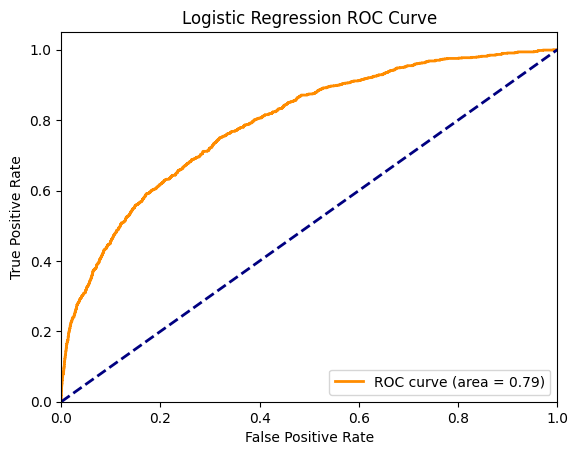

In [152]:
logistic_regression_dir = os.path.join('models', embedding_type, 'logistic_regression')
logistic_regression_model_path = os.path.join(logistic_regression_dir, 'logistic_regression_pca99.joblib')
logistic_regression_pca_dict_path = os.path.join(logistic_regression_dir, 'pca_objects99.joblib')

plot_logistic_regression_roc(
    logistic_regression_model_path,
    final_data,
    pca_dict_path=logistic_regression_pca_dict_path,
)

### XGBoost

In [116]:
def inference_xgb(
    features:pd.DataFrame,
    model_path,
    pca_dict_path,
    embedding_cols=None,
) -> float:
    if embedding_cols is None:
        embedding_cols = ['note_embedding', 'prescription_embedding']

    X = apply_inference_PCA_to_embeddings(
        features,
        embedding_cols=embedding_cols,
        pca_dict_path=pca_dict_path,
    )
    
    model = joblib.load(model_path)
    probs = model.predict_proba(X)
    
    print(f"XGBoost predicted {probs[0][1]*100:.2f}% mortality risk")
    return probs[0][1]

In [136]:
def plot_xgb_roc(
    model_path,
    data:pd.DataFrame,
    model_name:str='XGBoost',
    pca_dict_path=None,
    test_size=0.2,
    random_state=42,
    embedding_cols=None,
) -> None:
    if embedding_cols is None:
        embedding_cols = ['note_embedding', 'prescription_embedding']

    X, y, _ = apply_PCA_to_embeddings(
        data,
        pca_dict_path=pca_dict_path,
        is_inference=True,
        embedding_cols=embedding_cols,
    )
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    model = joblib.load(model_path)
    y_pred_probs = model.predict_proba(X_test)[:, 1]
    
    plot_roc_curve(y_test, y_pred_probs, model_name)
        

In [126]:
xgboost_dir = os.path.join('models', embedding_type, 'xgboost')
xgb_model_path = os.path.join(xgboost_dir, 'xgboost3_pca99.joblib')
xgb_pca_dict_path = os.path.join(xgboost_dir, 'pca_objects99.joblib')

sample_prediction = inference_xgb(
    features=merged_features,
    pca_dict_path=xgb_pca_dict_path,
    model_path=xgb_model_path,
)

Reduced note_embedding to 110 components with 0.9900 variance accounted for
Reduced prescription_embedding to 39 components with 0.9902 variance accounted for
Final features shape: (1, 168)
XGBoost predicted 38.03% mortality risk


Reduced note_embedding to 110 components with 0.9900 variance accounted for
Reduced prescription_embedding to 39 components with 0.9902 variance accounted for
Final features shape: (40900, 168)


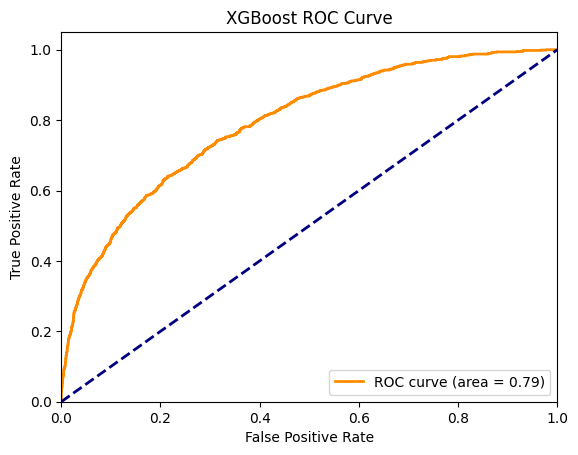

In [145]:
plot_xgb_roc(
    xgb_model_path,
    final_data,
    pca_dict_path=xgb_pca_dict_path,
)

### Neural Model

In [121]:
def inference_neural(
    features:pd.DataFrame,
    model_path,
    pca_dict_path,
    embedding_cols=None,
    hidden_dim:int=128,
    model_type:str='small',
    dropout:float=0.5,
    device:torch.device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):
    X = apply_inference_PCA_to_embeddings(
        features,
        embedding_cols=embedding_cols,
        pca_dict_path=pca_dict_path,
    )
    
    model = BinaryClassificationModel(
        input_dim=X.shape[1],
        hidden_dim=hidden_dim,
        model_type=model_type,
        dropout=dropout,
    ).to(device)

    model.load_state_dict(torch.load(model_path))
    model.eval()

    with torch.no_grad():
        inputs = torch.tensor(X.values, dtype=torch.float32).to(device)
        logits = model(inputs)
        
        probs = torch.sigmoid(logits)
        pred_prob = probs.cpu().numpy()[0][0]
        
    print(f"Neural network predicted {pred_prob*100:.2f}% mortality risk")
    return pred_prob

In [137]:
def plot_neural_roc(
    model_path,
    data:pd.DataFrame,
    model_name:str='Neural',
    embedding_cols=None,
    pca_dict_path=None,
    hidden_dim:int=128,
    model_type:str='small',
    dropout:float=0.5,
    device:torch.device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    test_size=0.2,
    random_state=42,
) -> None:
    X, y, _ = apply_PCA_to_embeddings(
        data,
        embedding_cols=embedding_cols,
        pca_dict_path=pca_dict_path,
        is_inference=True,
    )
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    model = BinaryClassificationModel(
        input_dim=X_test.shape[1],
        hidden_dim=hidden_dim,
        model_type=model_type,
        dropout=dropout,
    ).to(device)

    model.load_state_dict(torch.load(model_path))
    model.eval()

    with torch.no_grad():
        inputs = torch.tensor(X_test.values, dtype=torch.float32).to(device)
        logits = model(inputs)
        
        probs = torch.sigmoid(logits)
        y_pred = probs.cpu().numpy()

    plot_roc_curve(y_test, y_pred, model_name)
        

In [139]:
neural_model_dir = os.path.join('models', embedding_type, 'neural_classifier')

hidden_dim = 256
model_type = 'medium'
dropout = 0.5
bce_neural_model_path = os.path.join(neural_model_dir, 'auroc_hd256_medium_lr0.01_bs8192_dr0.5_ep100_bce_sp10_lrf0.1_es20_mpFalse_pca0.99.pth')
neural_pca_dict_path = os.path.join(neural_model_dir, 'pca_objects99.joblib')

neural_sample_prediction = inference_neural(
    features=merged_features,
    embedding_cols=['note_embedding', 'prescription_embedding'],
    model_path=bce_neural_model_path,
    pca_dict_path=neural_pca_dict_path,
    hidden_dim=hidden_dim,
    model_type=model_type,
    dropout=dropout,
)

Reduced note_embedding to 110 components with 0.9900 variance accounted for
Reduced prescription_embedding to 39 components with 0.9902 variance accounted for
Final features shape: (1, 168)
Neural network predicted 9.68% mortality risk


Reduced note_embedding to 110 components with 0.9900 variance accounted for
Reduced prescription_embedding to 39 components with 0.9902 variance accounted for
Final features shape: (40900, 168)


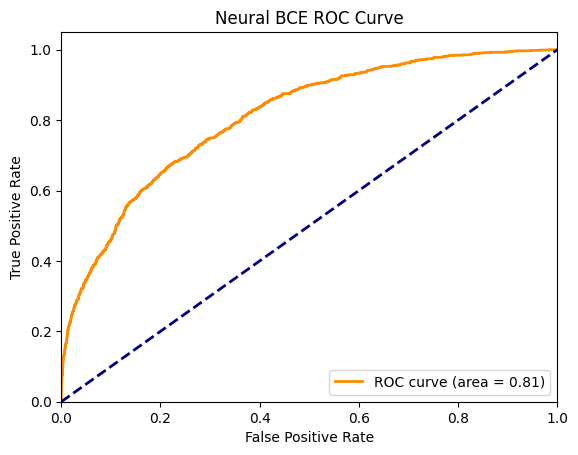

In [147]:
plot_neural_roc(
    model_path=neural_model_path,
    data=final_data,
    model_name='Neural BCE',
    pca_dict_path=neural_pca_dict_path,
    hidden_dim=hidden_dim,
    model_type=model_type,
    dropout=dropout,
)

Reduced note_embedding to 110 components with 0.9900 variance accounted for
Reduced prescription_embedding to 39 components with 0.9902 variance accounted for
Final features shape: (40900, 168)


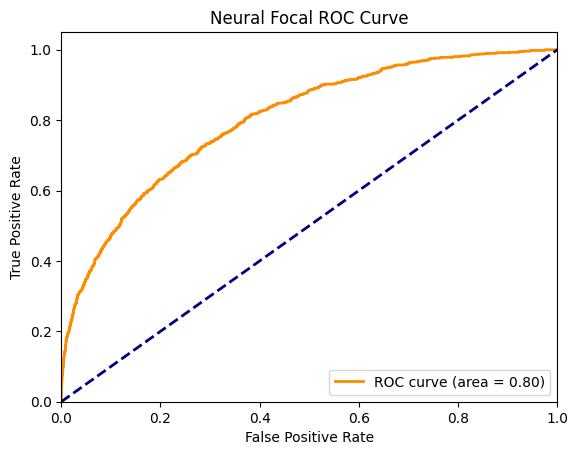

In [148]:
focal_neural_model_path = os.path.join(neural_model_dir, 'auroc_hd256_medium_lr0.01_bs8192_dr0.5_ep100_focal_sp10_es20_mpFalse_pca0.99.pth')

plot_neural_roc(
    model_path=focal_neural_model_path,
    data=final_data,
    model_name='Neural Focal',
    pca_dict_path=neural_pca_dict_path,
    hidden_dim=hidden_dim,
    model_type=model_type,
    dropout=dropout,
)